## **Walmart Sales in Stormy Weather Forecasting**

**Authors** <br>
Name: Nicole Li, Wen-Ling Chang

**Motivation**<br>

The goal of this project is to help grocer better understand the behavior of their customers. Specifically, when do customer make their purchases and what influences their decisions. We have broke down sales data from walmart into store specific items and generated variables such as holidays, days before holiday, seasons, weekday and weekend. We also linked these information with weather data whcih we have tested to see its importance. We found that products serving different needs will response to these variables on different scale. Some porduct are more sensitive to weather while other are more sensitive to day of the week and holidays. We hope these insights can help grocer in manging their inventory to avoid out of stocks which could be extremly costly for the business. 

**Conclusion** <br>

1. Different product reacts to different attributes. Therefore, if we put all products together to perform the analysis. The result would be less obvious.
2. Store 33 has the highest sales volumns across all stores.
3. Among store 33, we found that item 44 and item 9 may be daily necessities. Item 92, and item 93 may be products easily affected by weathers.
4. We picked item 44 and item 92 to perform the further analysis due to relatively more observe data on this two items.
5. After utilizing the machine learning model to perform the analysis. we found that:<br>

   a. Item 44: <br>
     a1) The volume of sales is stable over time.<br>
     a2) The best model can accurately predict long-term average sales volumes, but the outlier conditions can hardly be predicted. e.g. One possilbe outlier scenario: Increased demand for toilet paper due to coronavirus.<br>
     
   b. Item 92: <br>
    b1) The volume of sales is highly volatile over time. We guess this product could be a seasonal product.<br>
    b2) Item 92 is subject to cool, wind speed, and monthly precipitation variables. This result implies that colder days are correlated with the sales volumes of item 92.<br>


Import Libraries

In [1]:
# !pip install plotly==4.6

In [104]:
import pandas as pd  
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np  
import matplotlib.pyplot as plt 
from pandas.plotting import lag_plot
import plotly.express as px
import seaborn as sns
from datetime import timedelta

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from scipy.stats import ttest_ind
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import recall_score, accuracy_score
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import residuals_plot
from matplotlib.pyplot import figure

import plotly

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_rows=666
pd.options.display.max_columns = 70
pd.set_option('mode.chained_assignment', None)


In [3]:
#Code to be used on Google Colab
!pip install pydrive  

In [4]:
#Code to be used on Google Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Import file key in the google colab
file_id = '19CHyfgXnBttSskpo5PRR939LRQNTGzPD'  
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('key.csv')

file_id_2 = '1zpyriT0bTTmlchHUioyoGxs9nUym7UJy'  
downloaded_2 = drive.CreateFile({'id': file_id_2})
downloaded_2.GetContentFile('test.csv')

file_id_3 = '1SNGuoYkohXebL_jkEsheG5EQeGP52AND'  
downloaded_3 = drive.CreateFile({'id': file_id_3})
downloaded_3.GetContentFile('train.csv')

file_id_4 = '1FfGqMsS0Ht9tt8001mO5BfE4IA7bq82n'  
downloaded_4 = drive.CreateFile({'id': file_id_4})
downloaded_4.GetContentFile('weather.csv')

Read Dataset

In [5]:
df = pd.read_csv("train.csv")
key = pd.read_csv("key.csv")
weather = pd.read_csv("weather.csv")

Merge the sales data with weather data, takes a few minute (data is large)

In [6]:
df1 = df.merge(key, on = "store_nbr", how = "left")
df2 = df1.merge(weather, left_on  = ["station_nbr","date"], right_on  = ["station_nbr","date"], how = "left")

### Data Cleaning 

Dataset has filler information when store does not sell a item the units are filled with 0. We remove these rows when item is not been sold at the store. Make sure there are no duplicates

In [7]:
all_combo = df2.groupby(["item_nbr","store_nbr"])["units"].sum().reset_index() 
to_drop = all_combo[all_combo.units == 0 ]

df3 = df2.merge(to_drop, on = ["item_nbr","store_nbr"], how = "left")
df4 = df3[df3.units_y.isnull()]
df4.drop("units_y", axis = 1, inplace = True)

#df4[df4.duplicated()] 

Cleaning data and converting to appropriate datatype
- sunset and sunrise is turned to number to give valid comparison
- Codesum attribute will be used for target encoding

In [8]:
df4['date'] = pd.to_datetime(df4['date'],format='%Y-%m-%d')
df4.replace('-','00',inplace=True)
df4.replace('  T','0',inplace=True)
df4.replace('M','0',inplace=True)

In [9]:
df4.iloc[:,1:13] = df4.iloc[:,1:13].astype("int")
df4["sunrise"] = df4.sunrise.apply(lambda x: int(x[1:]))
df4["sunset"]= df4.sunset.apply(lambda x: int(x))

In [10]:
df4.iloc[:,16:] = df4.iloc[:,16:].astype("float")
df4.rename(columns = {"units_x":"units"}, inplace = True) 

In [11]:
df4.dtypes

date           datetime64[ns]
store_nbr               int32
item_nbr                int32
units                   int32
station_nbr             int32
tmax                    int32
tmin                    int32
tavg                    int32
depart                  int32
dewpoint                int32
wetbulb                 int32
heat                    int32
cool                    int32
sunrise                 int64
sunset                  int64
codesum                object
snowfall              float64
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir             float64
avgspeed              float64
dtype: object

## Feature Engineering 

Focuse on creating event features based on date value since weather shown no significant correlation in later testing.

Creating holiday boolean

In [12]:
cal = calendar()
holidays = cal.holidays(start=df4.date.min(), end=df4.date.max())
df4["holidays"] = pd.to_datetime(df4.date,format="%Y-%m-%d").isin(holidays).tolist()

Create pre holiday column (1,2,3 days before holiday)

In [13]:
pre_holiday = []
for day in holidays:
    pre_holiday.append(day-timedelta(days=1))
    pre_holiday.append(day-timedelta(days=2))
    pre_holiday.append(day-timedelta(days=3))
df4["pre_holidays"] = pd.to_datetime(df4.date,format="%Y-%m-%d").isin(pre_holiday).tolist()

Create weekday, weekend, month

In [14]:
df4["weekday"] = pd.to_datetime(df4.date,format = '%Y-%m-%d').dt.weekday
df4["weekday"] = df4["weekday"].apply(lambda x: x+1)
df4["weekend"] = df4.weekday.apply(lambda x: 1 if (x>5) else 0)
df4["weekday"] = df4["weekday"].astype("str")
df4["weekday_name"] = pd.to_datetime(df4.date,format = '%Y-%m-%d').dt.day_name()
df4["month"] = pd.to_datetime(df4.date,format = '%Y-%m-%d').dt.month

Creating seasons column

In [15]:
Spring=[3, 4, 5]
Summer=[6, 7, 8]
Winter=[12, 1, 2]

Season=[]
for i in df4['month']:
    if i in Spring:
        Season.append('Spring')
    elif i in Summer:
        Season.append('Summer')
    elif i in Winter:
        Season.append('Winter')
    else:
        Season.append('Fall')
df4['Season']=Season

Final Dataframe with additional features to work with.

In [16]:
df4.head()

date  store_nbr  item_nbr  units  station_nbr  tmax  tmin  tavg  \
8  2012-01-01          1         9     29            1    52    31    42   
27 2012-01-01          1        28      2            1    52    31    42   
39 2012-01-01          1        40      0            1    52    31    42   
46 2012-01-01          1        47      0            1    52    31    42   
50 2012-01-01          1        51      1            1    52    31    42   

    depart  dewpoint  wetbulb  heat  cool  sunrise  sunset     codesum  \
8        0        36       40    23     0        0       0  RA FZFG BR   
27       0        36       40    23     0        0       0  RA FZFG BR   
39       0        36       40    23     0        0       0  RA FZFG BR   
46       0        36       40    23     0        0       0  RA FZFG BR   
50       0        36       40    23     0        0       0  RA FZFG BR   

    snowfall  preciptotal  stnpressure  sealevel  resultspeed  resultdir  \
8        0.0         0.05        29.78     29.92          3.6       20.0   
27       0.0         0.05        29.78     29.92          3.6       20.0   
39       0.0         0.05        29.78     29.92          3.6       20.0   
46       0.0         0.05        29.78     29.92          3.6       20.0   
50       0.0         0.05        29.78     29.92          3.6       20.0   

    avgspeed  holidays  pre_holidays weekday  weekend weekday_name  month  \
8        4.6     False          True       7        1       Sunday      1   
27       4.6     False          True       7        1       Sunday      1   
39       4.6     False          True       7        1       Sunday      1   
46       4.6     False          True       7        1       Sunday      1   
50       4.6     False          True       7        1       Sunday      1   

    Season  
8   Winter  
27  Winter  
39  Winter  
46  Winter  
50  Winter

## Exploration

Let see how many stores and items are in our dataset

In [17]:
print(f'We have {df4.item_nbr.nunique()} items from {df4.store_nbr.nunique()} stores')

We have 111 items from 45 stores


There are few stores that tends to sell more overall

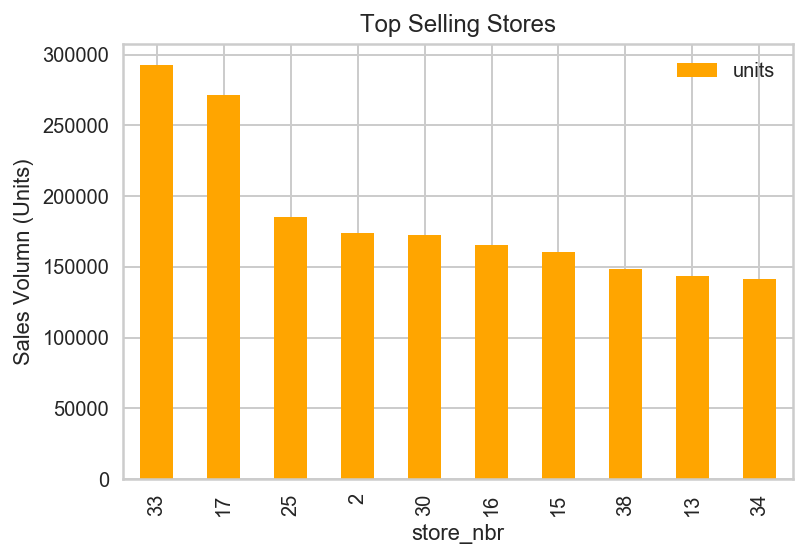

In [18]:
plt0 = df4.groupby("store_nbr")["units"].sum().sort_values(ascending = False)[:10].to_frame().plot(kind = "bar",color="orange")
plt.title("Top Selling Stores")
plt.ylabel("Sales Volumn (Units)")
display(plt0)

There are few items that tends to sell more 

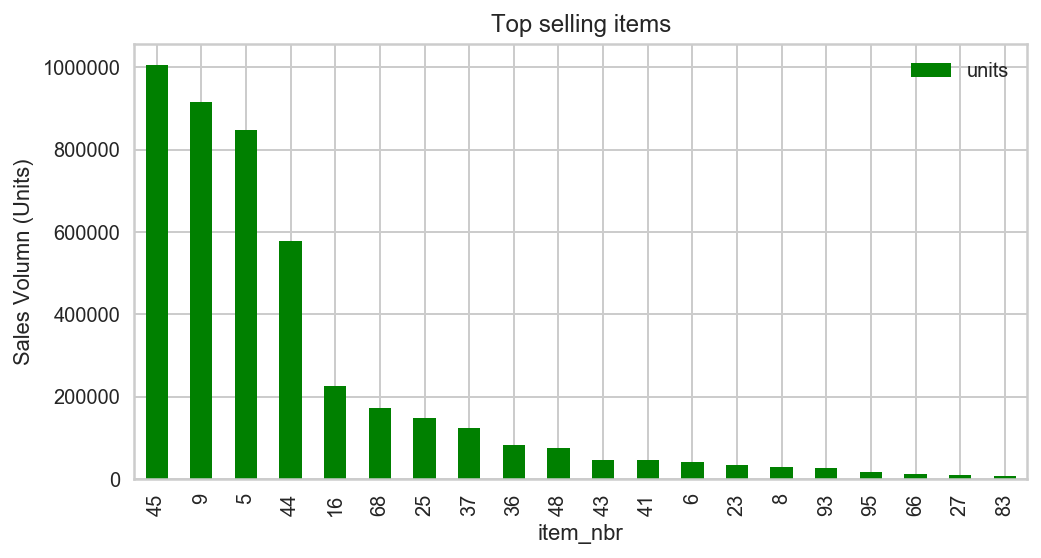

In [19]:
plt1 = df4.groupby("item_nbr")["units"].sum().sort_values(ascending = False)[:20].to_frame().plot(kind = "bar",
                                                                                                  color = "green",
                                                                                                  figsize = (8,4))
plt.title("Top selling items")
plt.ylabel("Sales Volumn (Units)")
display(plt1) 

### Analysis on Store with highest Sales Volumn: Store 33

- Need to break data down to specific store and item to show true interaction
- Combination of all store and items gives no significant insights due to following reasons:
    - Store sales of same item differs
    - Similar items are given different item_nbr when they are different brand, and can act as substitutes
    - Different items react different to events such as weather, holiday, weekend, season, and month
    - Combination of above 3 will create noise between products and store that does not give clear insight

In [20]:
str33 = df4[df4.store_nbr==33]
items = str33.item_nbr.unique()
print(f'Store 33 sells item: {sorted(items)}')

Store 33 sells item: [9, 44, 85, 92, 93]


Notice item 9 and 44 are one of the best selling items for all store combined so these might be daily essentials such as milk and bread. While sales for 93, 92,  85 are much lower overall. Thus it might be worth comparing how these item react differently to weather, weekday, month, holiday and seasonality. 

In [21]:
mean = str33.groupby("item_nbr")["units"].mean().to_frame()
total = str33.groupby("item_nbr")["units"].sum().to_frame()
mean.merge(total, on = "item_nbr").rename(columns = {"units_x":"mean", "units_y":"total"})

mean   total
item_nbr                    
9         111.144420  101586
44        207.771335  189903
85          0.082057      75
92          0.792123     724
93          0.358862     328

We have verfied 9 and 44 are stables that may have been sold daily and that 85, 92, 93 are special items. We need to make sure the these sales units are a true representation and store 33 is not a outlier in terms of sales. So we look at sales of these items at all the other stores to make sure store 33 is not given these item special promotion or just have these item placed at a bad location causing sales to be lower than usual.

In [22]:
strs = df4[df4.store_nbr!=33]
strs_not33= strs[strs.item_nbr.isin(items)]

mean = strs_not33.groupby("item_nbr")["units"].mean().to_frame()
total = strs_not33.groupby("item_nbr")["units"].sum().to_frame()
mean.merge(total, on = "item_nbr").rename(columns = {"units_x":"mean", "units_y":"total"})

mean   total
item_nbr                    
9          54.194361  815029
44        106.956642  387290
85          0.099885     173
93          1.069236   27582

Sales volumn of item 44 and 9 makes up majority of all sales. With store 33 responsible for high porportion of sales
- Observe that store 33 is actually the only store selling item 92
- Store 33 sales units is a good representation of the overall picture 

In [184]:
all_strs= df4[df4.item_nbr.isin(items)]
px.treemap(all_strs, path = ["item_nbr","store_nbr"], values = "units")

## Identify features that correlates with sales units for store 33

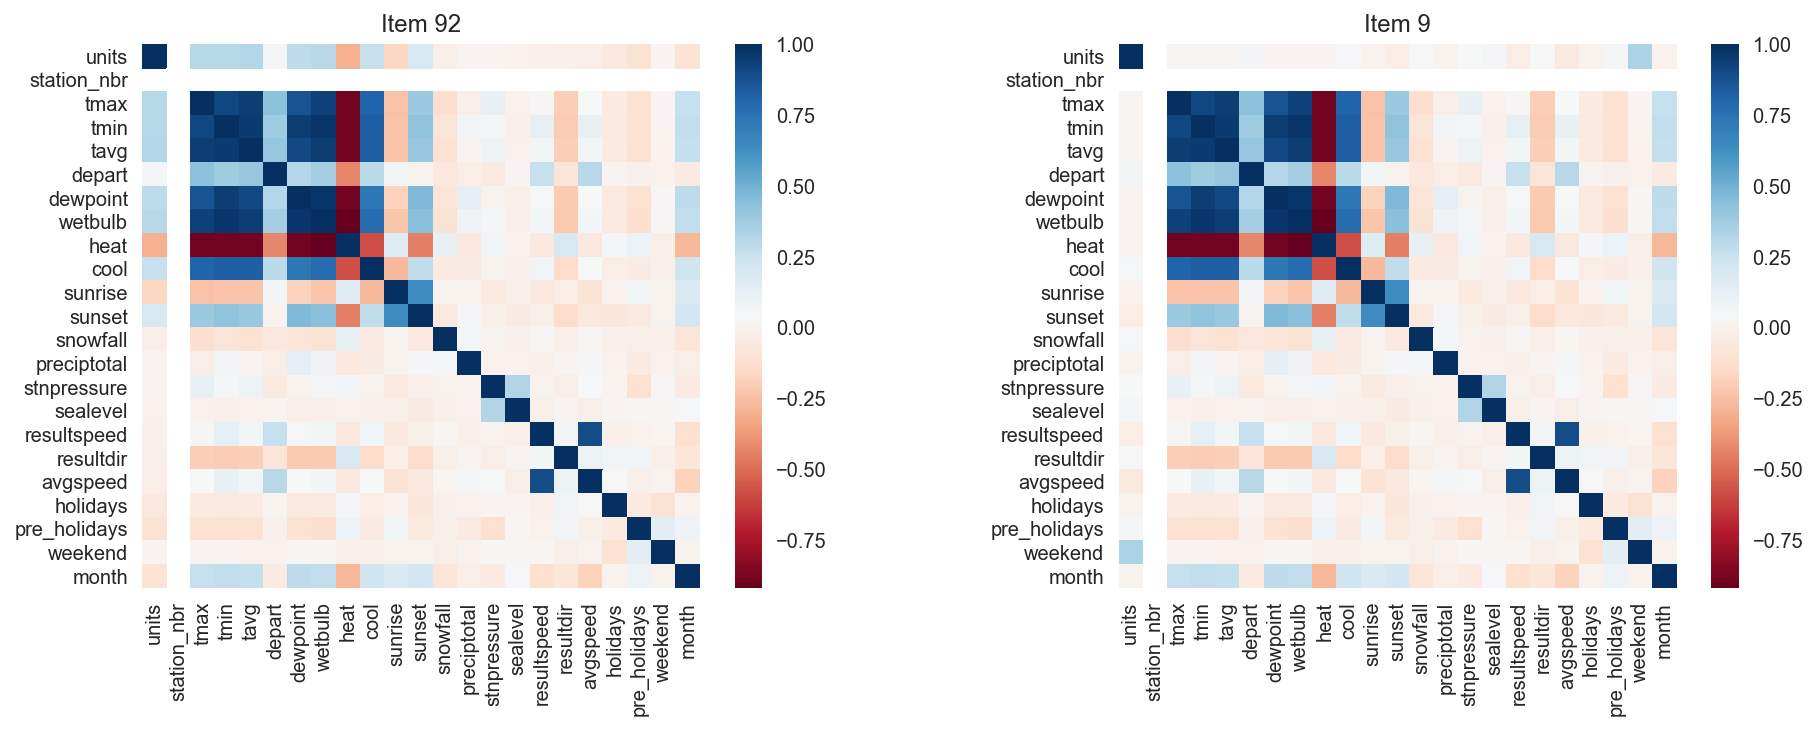

In [24]:
fig, ax =plt.subplots(1,2, figsize=(15,5))

ax[0].set_title('Item 92')
str33itm92 = str33[str33.item_nbr==92]
corrmatrix  = str33itm92.iloc[:,3:].corr()
sns.heatmap(corrmatrix, ax=ax[0], cmap="RdBu")

ax[1].set_title('Item 9')
str33itm9 = str33[str33.item_nbr==9]
corrmatrix  = str33itm9.iloc[:,3:].corr()
sns.heatmap(corrmatrix, ax=ax[1], cmap="RdBu")

fig.subplots_adjust(wspace=.4, hspace=.01)

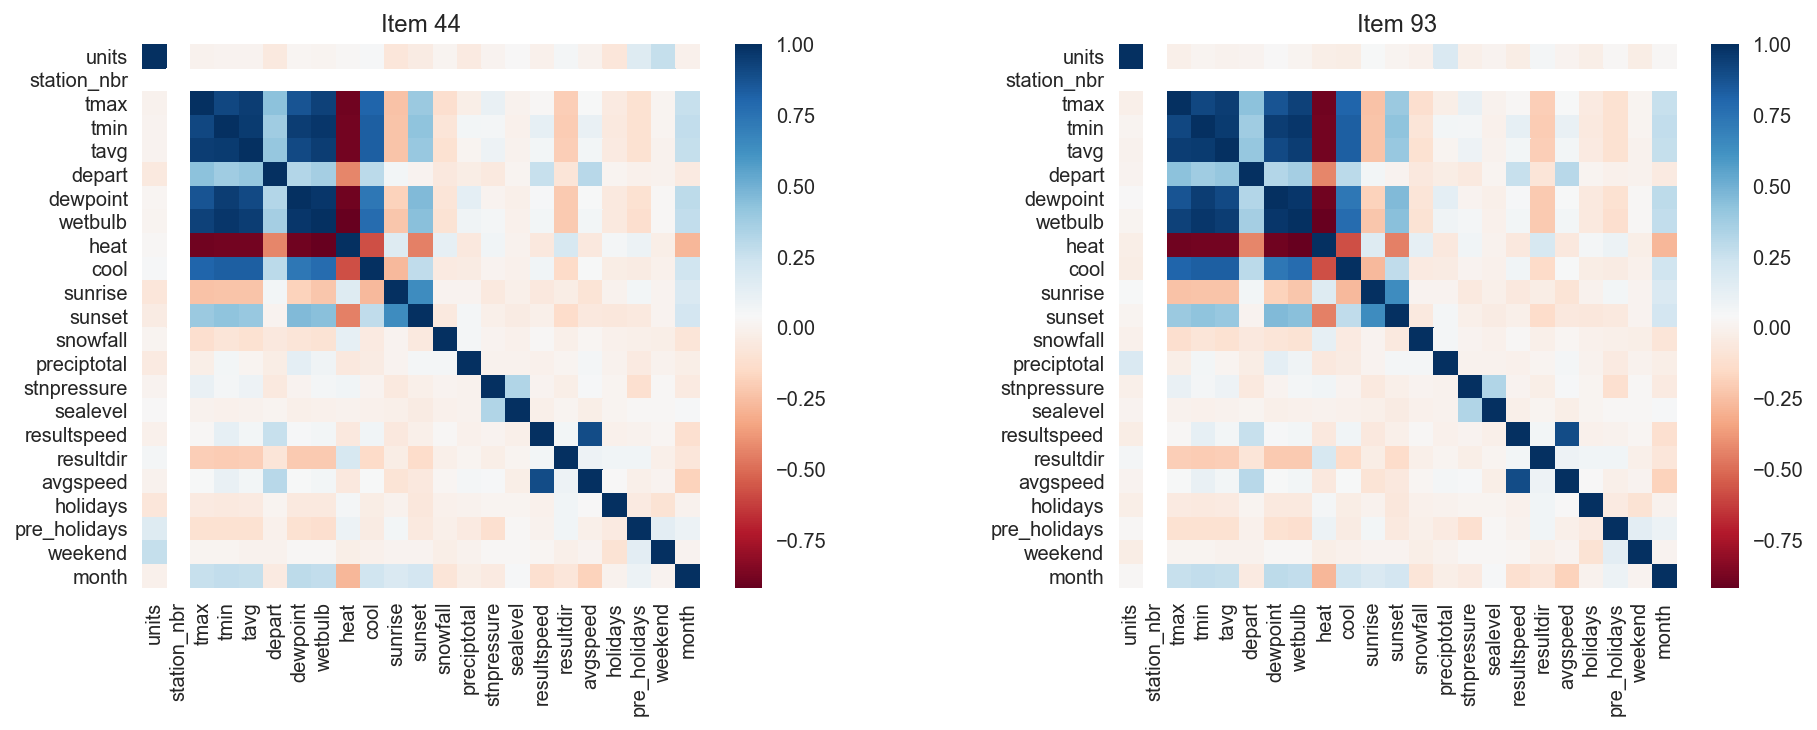

In [25]:
fig, ax =plt.subplots(1,2, figsize=(15,5))

ax[0].set_title('Item 44')
str33itm44 = str33[str33.item_nbr==44]
corrmatrix  = str33itm44.iloc[:,3:].corr()
sns.heatmap(corrmatrix, ax=ax[0], cmap="RdBu")

ax[1].set_title('Item 93')
str33itm93 = str33[str33.item_nbr==93]
corrmatrix  = str33itm93.iloc[:,3:].corr()
sns.heatmap(corrmatrix, ax=ax[1], cmap="RdBu")

fig.subplots_adjust(wspace=.4, hspace=.01)

Observation: 
- Item 92 has a stronger correlation weather variables.
    - Positive corellation with temperature, dewpoint, wetbulb, cool. 
    - Negative correlation with cool
- Item 93 has positive correlation with precipitation total
- Item 9 does not react to weather at all but is sensitive to weekend value.
- Item 44 correlates to both weekend and pre-holiday
- We can conclude these two items are sensitive to different types of events

### Weekday Sales Comparison of item 92, 9, 93, 44
- Both item 9 and 44 have very high sales volumn everyday of the week, sales also tend to peak on weekend
- Item 92 and 93 sales are much smaller in comparision
    - 92 does not respond to weekday, while we see a sudden peak for 93 on fridays

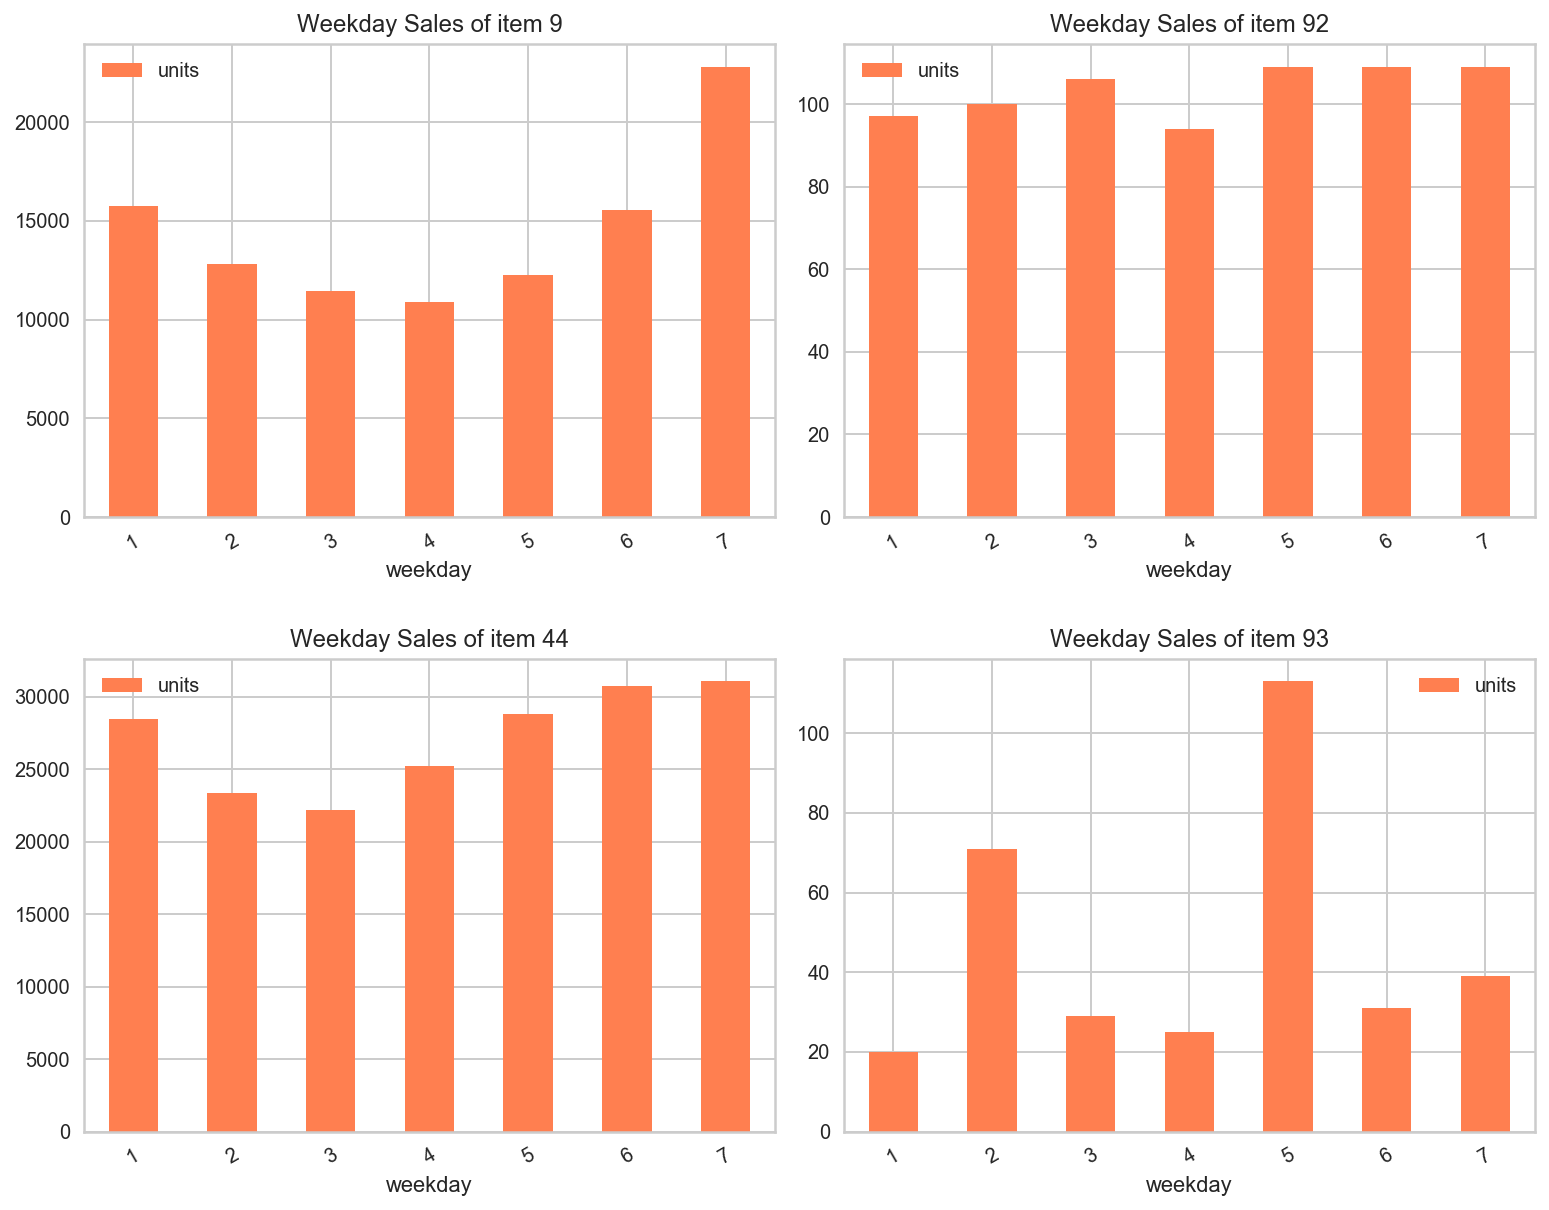

In [26]:
fig, ax =plt.subplots(2,2, figsize=(13,10))
fig.subplots_adjust(wspace=.1, hspace=.3)
plt2 = str33itm9.groupby("weekday")["units"].sum().to_frame().plot(kind = "bar", 
                                                                   color = "coral", 
                                                                   rot=30, 
                                                                   ax=ax[0,0], 
                                                                   title="Weekday Sales of item 9")
plt2 = str33itm92.groupby("weekday")["units"].sum().to_frame().plot(kind = "bar", 
                                                                   color = "coral", 
                                                                   rot=30, 
                                                                   ax=ax[0,1], 
                                                                   title="Weekday Sales of item 92")

plt2 = str33itm44.groupby("weekday")["units"].sum().to_frame().plot(kind = "bar", 
                                                                   color = "coral", 
                                                                   rot=30, 
                                                                   ax=ax[1,0], 
                                                                   title="Weekday Sales of item 44")

plt2 = str33itm93.groupby("weekday")["units"].sum().to_frame().plot(kind = "bar", 
                                                                   color = "coral", 
                                                                   rot=30, 
                                                                   ax=ax[1,1], 
                                                                   title="Weekday Sales of item 93")

####  Month to month comparison for items 9, 92, 44, 93
- We see item 92 and 93 to vary due to month, which could also be indicative of relation with weather and linked to seasonality
- We see item 9 and 44 to stay relatively stable which is also supportive of our assumption that these are daily essentials such as milk and bread. 

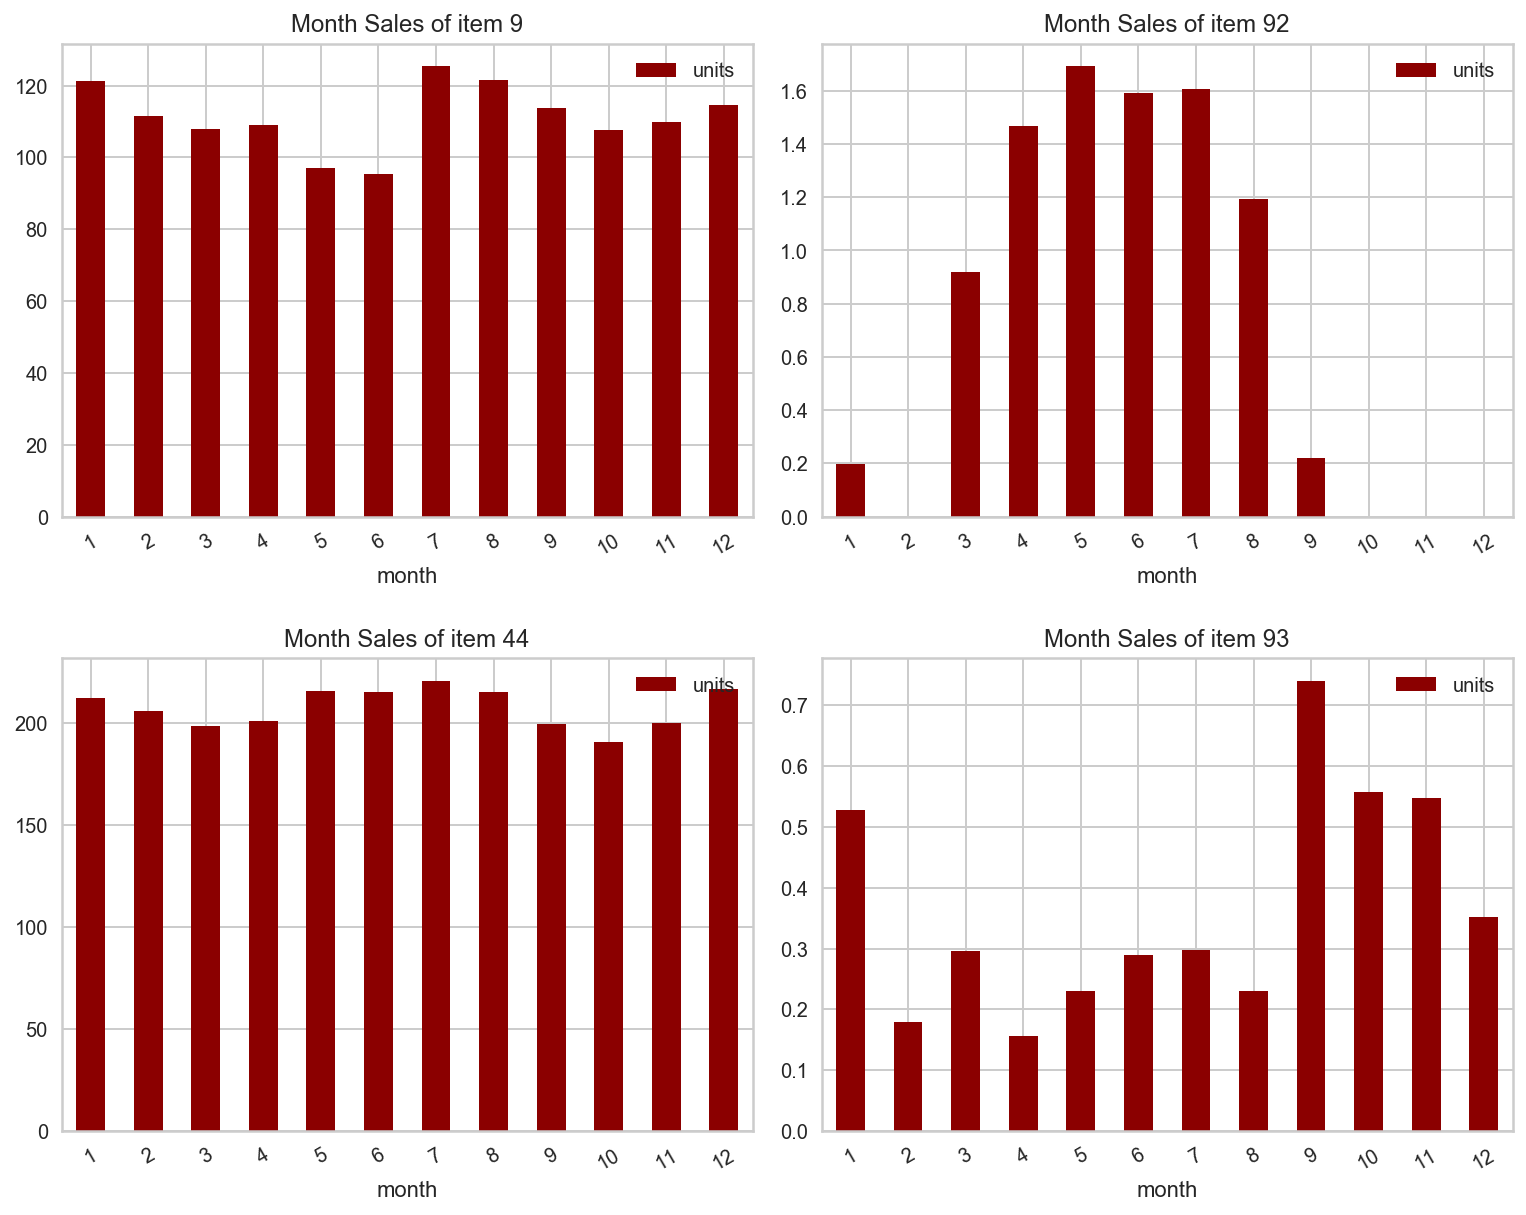

In [27]:
fig, ax =plt.subplots(2,2, figsize=(13,10))
fig.subplots_adjust(wspace=.1, hspace=.3)
plt2 = str33itm9.groupby("month")["units"].mean().to_frame().plot(kind = "bar", 
                                                                   color = "darkred", 
                                                                   rot=30, 
                                                                   ax=ax[0,0], 
                                                                   title="Month Sales of item 9")
plt2 = str33itm92.groupby("month")["units"].mean().to_frame().plot(kind = "bar", 
                                                                   color = "darkred", 
                                                                   rot=30, 
                                                                   ax=ax[0,1], 
                                                                   title="Month Sales of item 92")

plt2 = str33itm44.groupby("month")["units"].mean().to_frame().plot(kind = "bar", 
                                                                   color = "darkred", 
                                                                   rot=30, 
                                                                   ax=ax[1,0], 
                                                                   title="Month Sales of item 44")

plt2 = str33itm93.groupby("month")["units"].mean().to_frame().plot(kind = "bar", 
                                                                   color = "darkred", 
                                                                   rot=30, 
                                                                   ax=ax[1,1], 
                                                                   title="Month Sales of item 93")

Looking at sales throughout the year

Text(0.5, 1.0, 'Sales Volumn of item 9 from 2012 to 2014')

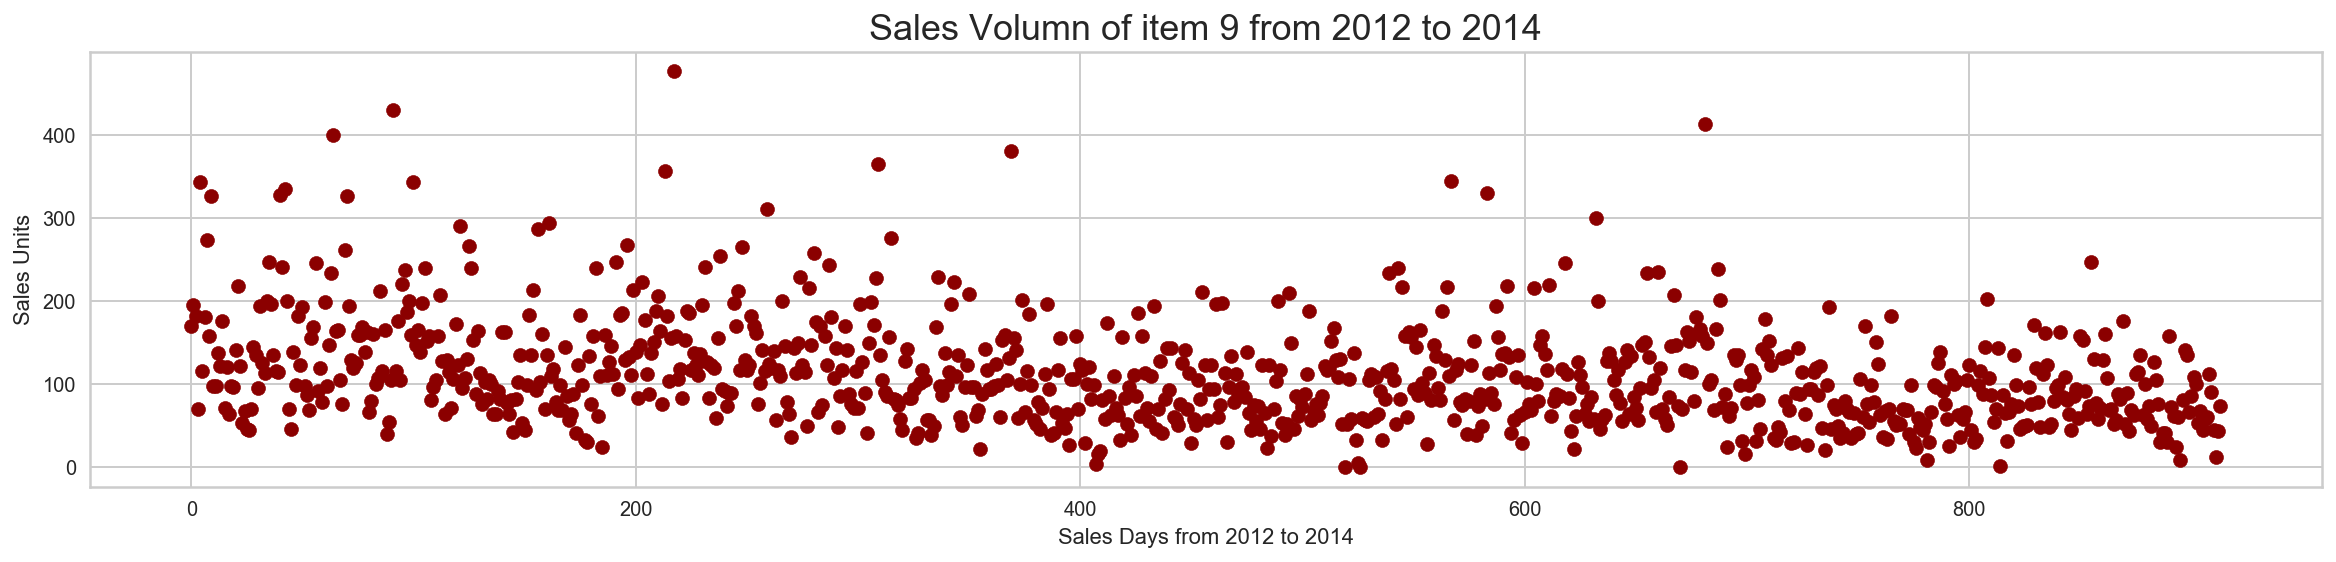

In [28]:
plt.figure(figsize = (20,4))
ax = plt.scatter(x = range(0,len(str33itm9)), y = str33itm9.units,color = "darkred")
plt.ylabel("Sales Units")
plt.xlabel("Sales Days from 2012 to 2014")
plt.title("Sales Volumn of item 9 from 2012 to 2014", fontsize = 18)

Text(0.5, 1.0, 'Sales Volumn of item 92 from 2012 to 2014')

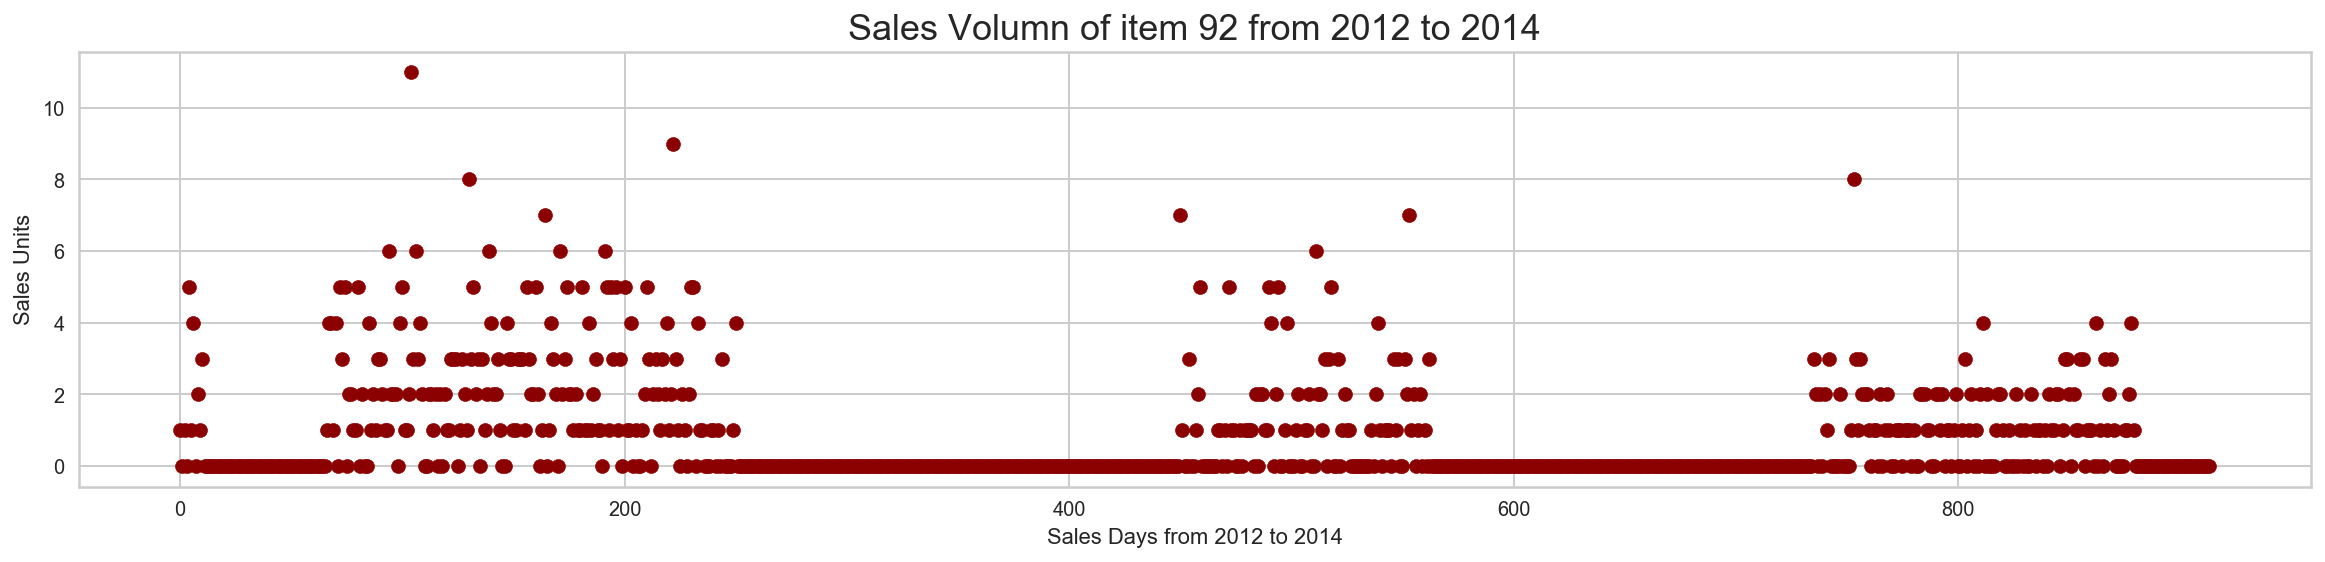

In [29]:
plt.figure(figsize = (20,4))
ax = plt.scatter(x = range(0,len(str33itm92)), y = str33itm92.units,color = "darkred")
plt.ylabel("Sales Units")
plt.xlabel("Sales Days from 2012 to 2014")
plt.title("Sales Volumn of item 92 from 2012 to 2014", fontsize = 18)

#### Seasonality Sales Comparison of item 92, 9, 93, 44
- Item 92 and 93 are very much influenced to temperature and thus we see the link to seasonlity. 
- Item 9 and 44 sales does not change, in combination with its high sales volumn, it is likely these two items are often bought as daily essentials. 

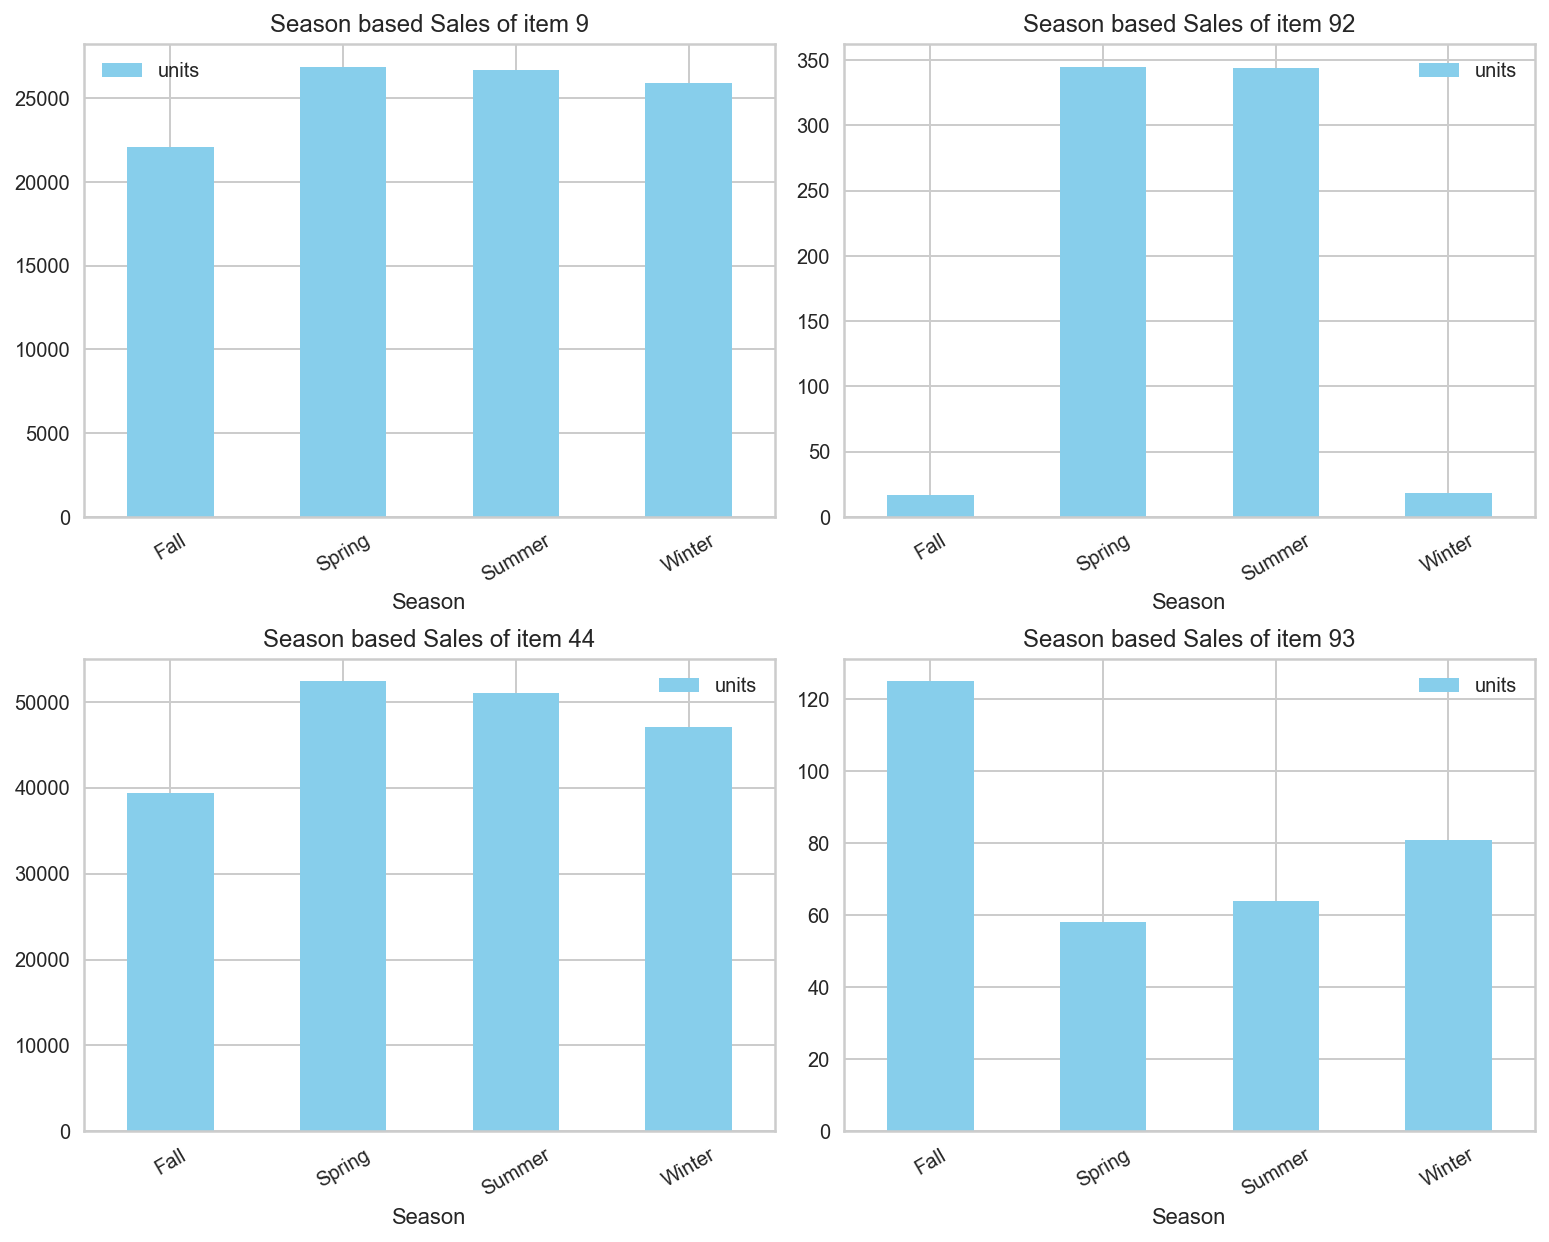

In [30]:
fig, ax =plt.subplots(2,2, figsize=(13,10))
fig.subplots_adjust(wspace=.1, hspace=.3)
plt2 = str33itm9.groupby("Season")["units"].sum().to_frame().plot(kind = "bar", 
                                                                   color = "skyblue", 
                                                                   rot=30, 
                                                                   ax=ax[0,0], 
                                                                   title="Season based Sales of item 9")
plt2 = str33itm92.groupby("Season")["units"].sum().to_frame().plot(kind = "bar", 
                                                                   color = "skyblue", 
                                                                   rot=30, 
                                                                   ax=ax[0,1], 
                                                                   title="Season based Sales of item 92")

plt2 = str33itm44.groupby("Season")["units"].sum().to_frame().plot(kind = "bar", 
                                                                   color = "skyblue", 
                                                                   rot=30, 
                                                                   ax=ax[1,0], 
                                                                   title="Season based Sales of item 44")
plt2 = str33itm93.groupby("Season")["units"].sum().to_frame().plot(kind = "bar", 
                                                                   color = "skyblue", 
                                                                   rot=30, 
                                                                   ax=ax[1,1], 
                                                                   title="Season based Sales of item 93")

#### Holiday Sales Comparison of item 92, 9, 93, 44
Holiday is a influencer for item 44 while other items are not as much responsive

Text(0.5, 1.0, 'Item 93')

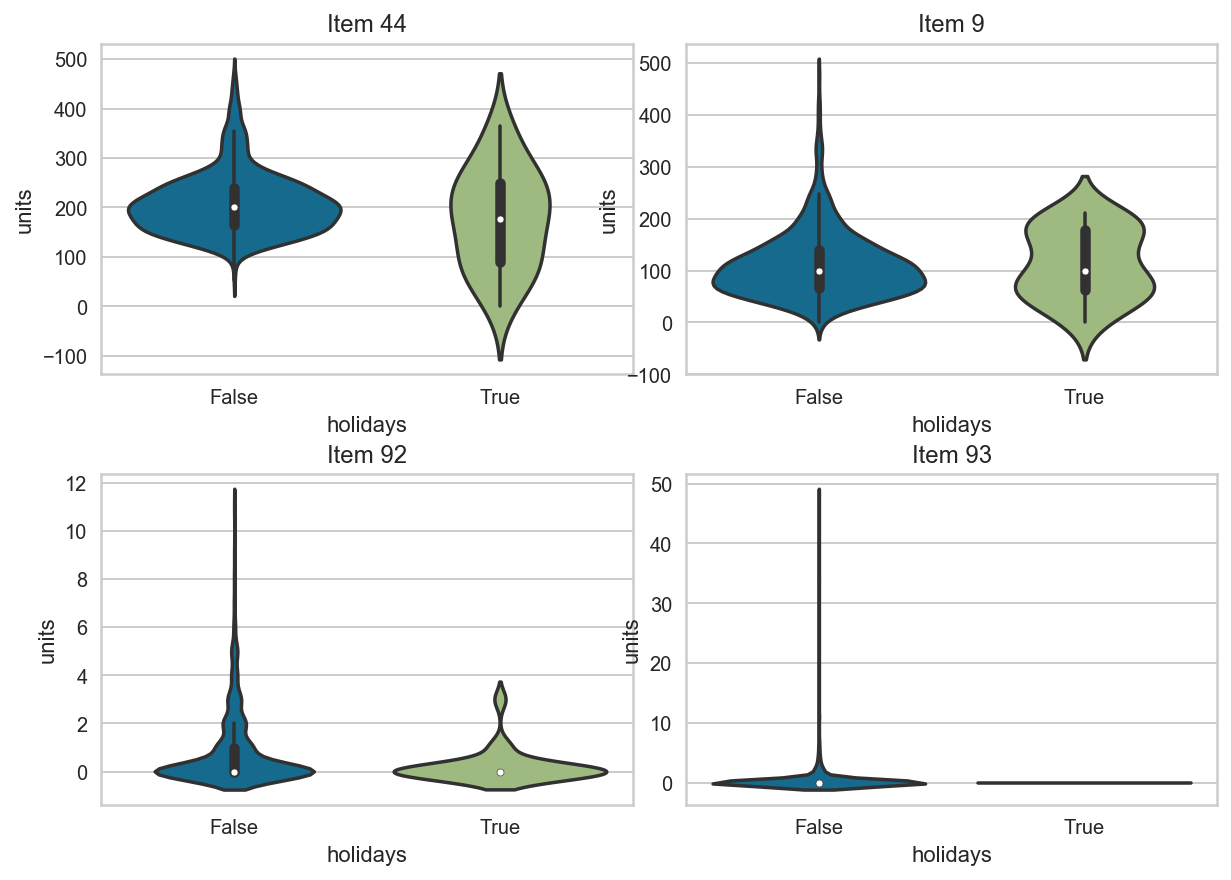

In [31]:
fig, ax =plt.subplots(2,2, figsize=(10,7))
fig.subplots_adjust(wspace=.1, hspace=.3)

sns.violinplot(x='holidays', y='units', ax = ax[0,0], data=str33itm44)
sns.violinplot(x='holidays', y='units', ax = ax[0,1], data=str33itm9)
sns.violinplot(x='holidays', y='units', ax = ax[1,0], data=str33itm92)
sns.violinplot(x='holidays', y='units', ax = ax[1,1], data=str33itm93)

ax[0,0].set_title('Item 44')
ax[0,1].set_title('Item 9')
ax[1,0].set_title('Item 92')
ax[1,1].set_title('Item 93')

#### Pre Holiday Sales Comparison of item 92, 9, 93, 44
Pre Holiday has a even stronger impact on item 44 than holiday. So we know this is an item that people like to stock up on before the holiday.

Text(0.5, 1.0, 'Item 93')

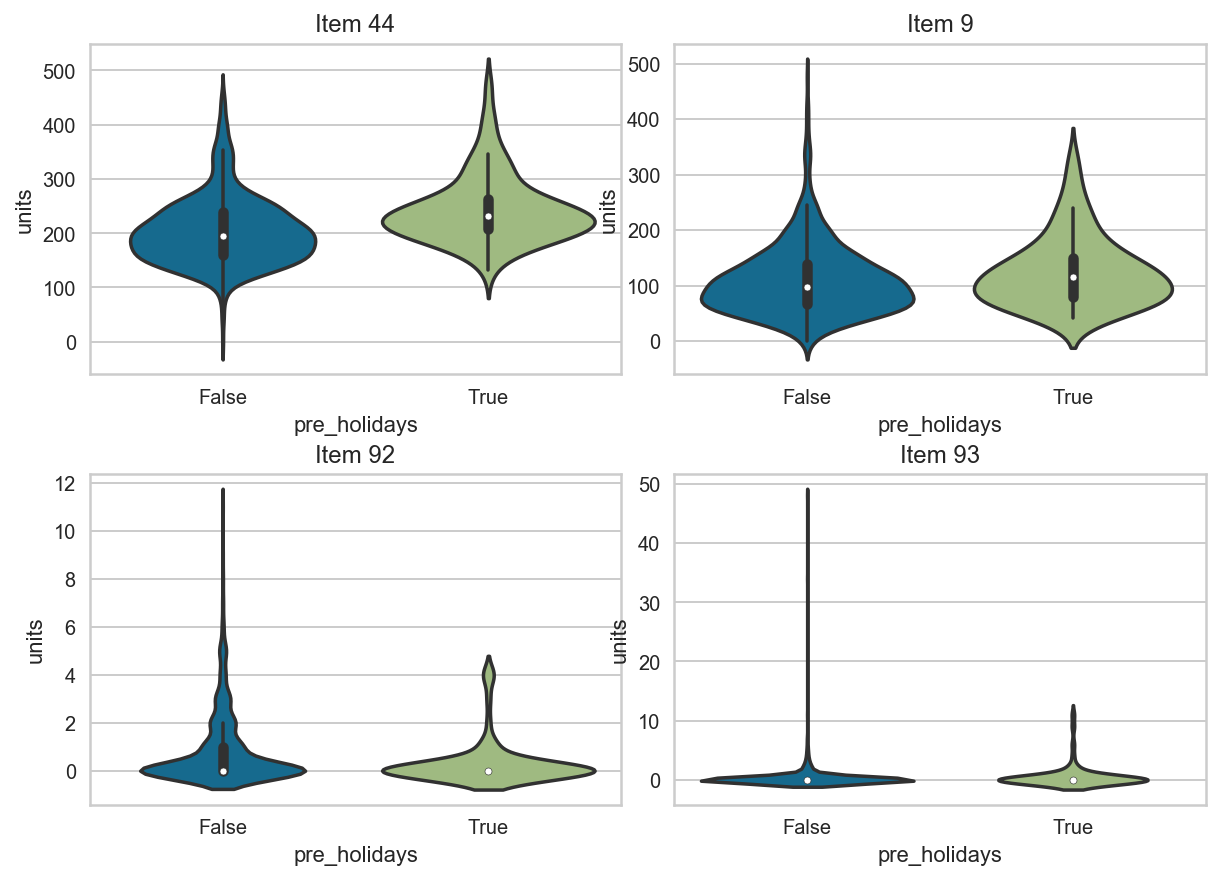

In [32]:
fig, ax =plt.subplots(2,2, figsize=(10,7))
fig.subplots_adjust(wspace=.1, hspace=.3)

sns.violinplot(x='pre_holidays', y='units', ax = ax[0,0], data=str33itm44)
sns.violinplot(x='pre_holidays', y='units', ax = ax[0,1], data=str33itm9)
sns.violinplot(x='pre_holidays', y='units', ax = ax[1,0], data=str33itm92)
sns.violinplot(x='pre_holidays', y='units', ax = ax[1,1], data=str33itm93)

ax[0,0].set_title('Item 44')
ax[0,1].set_title('Item 9')
ax[1,0].set_title('Item 92')
ax[1,1].set_title('Item 93')

## Checking Distribution of Weather data for store 33

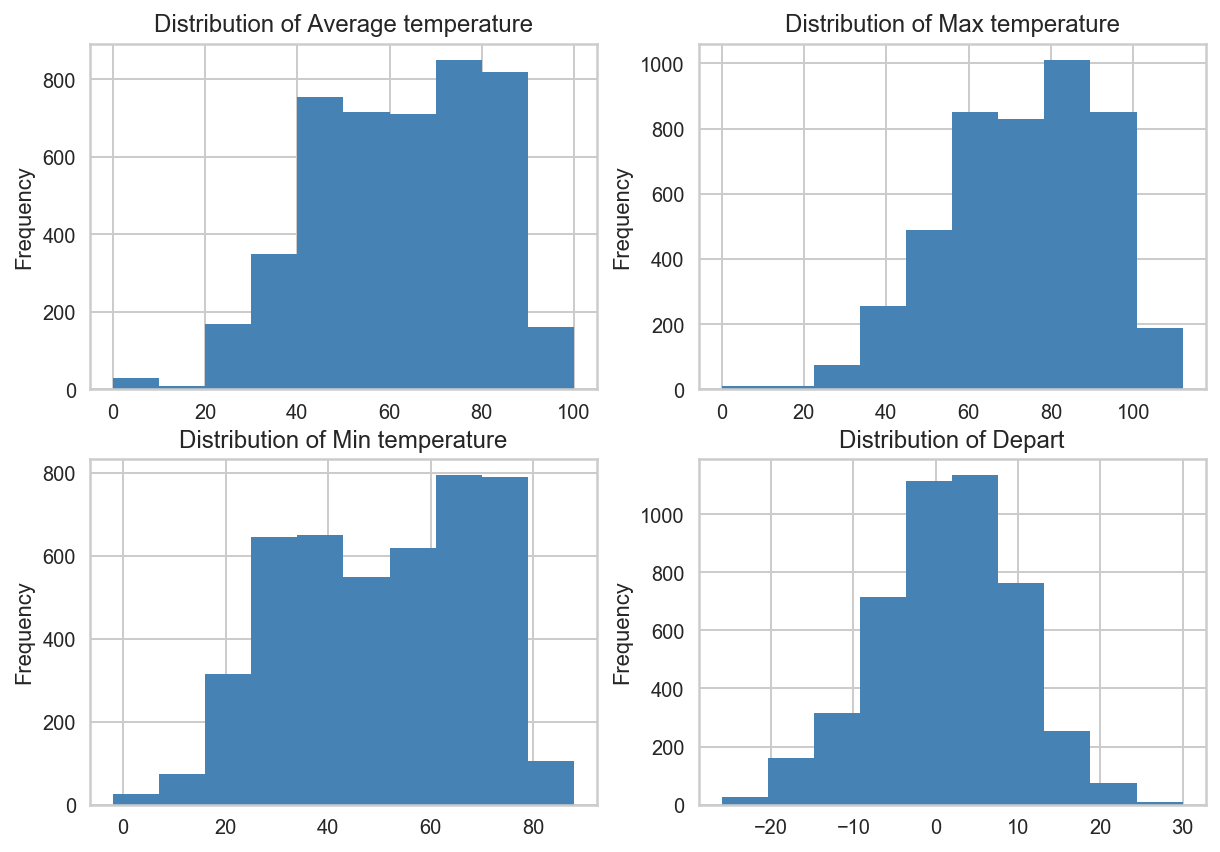

In [33]:
fig, ax =plt.subplots(2,2, figsize=(10,7))

str33.tavg.plot(kind="hist", ax = ax[0,0], title="Distribution of Average temperature",color="steelblue")
str33.tmax.plot(kind="hist", ax = ax[0,1], title="Distribution of Max temperature",color="steelblue")
str33.tmin.plot(kind="hist", ax = ax[1,0], title="Distribution of Min temperature",color="steelblue")
str33.depart.plot(kind="hist", ax = ax[1,1], title="Distribution of Depart",color="steelblue")

Some temperature variables are skewed and may need to be normalize for modeling

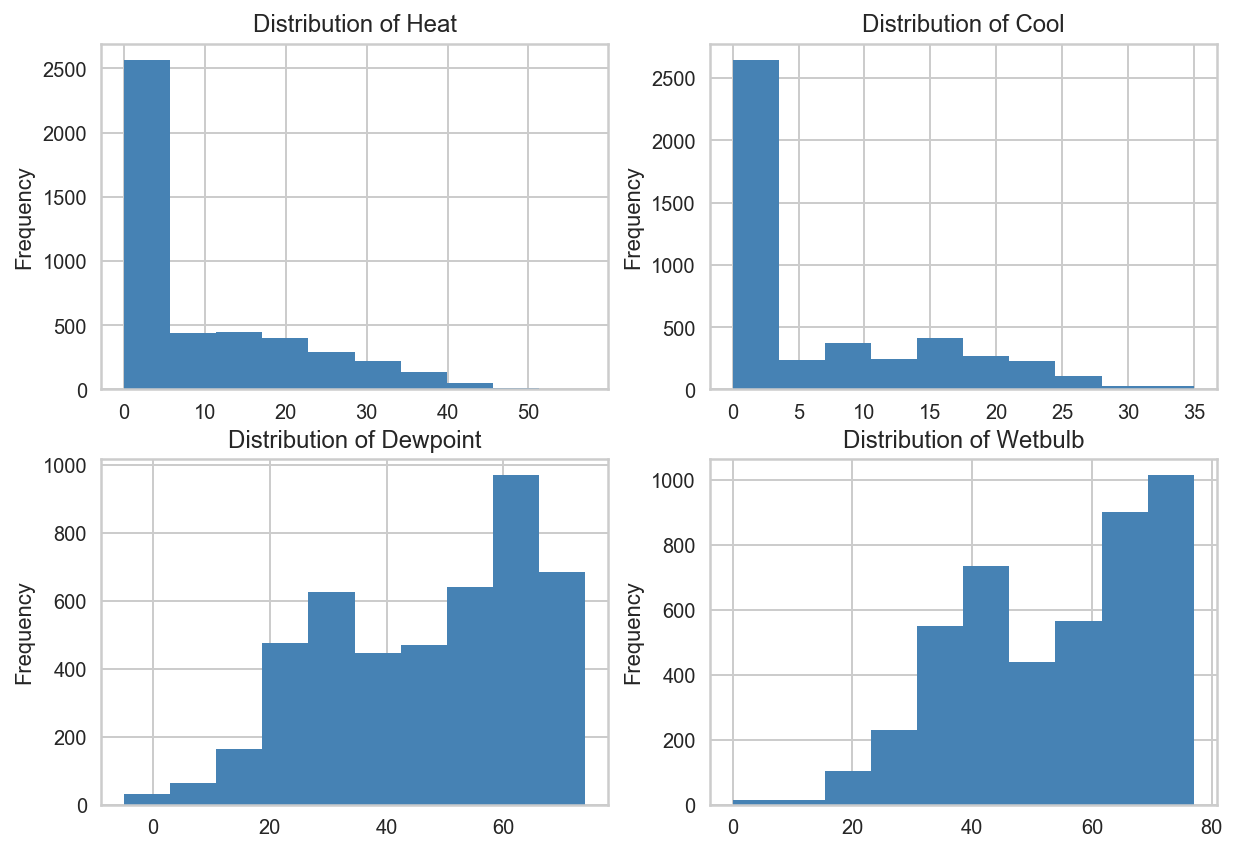

In [34]:
fig, ax =plt.subplots(2,2, figsize=(10,7))

str33.heat.plot(kind="hist", ax = ax[0,0], title="Distribution of Heat",color="steelblue")
str33.cool.plot(kind="hist", ax = ax[0,1], title="Distribution of Cool",color="steelblue")
str33.dewpoint.plot(kind="hist", ax = ax[1,0], title="Distribution of Dewpoint",color="steelblue")
str33.wetbulb.plot(kind="hist", ax = ax[1,1],  title="Distribution of Wetbulb",color="steelblue")

Distribution of avgspeed, resultspeed, resultdir. (Mostly zeros in 'snowfall', 'preciptotal', 'stnpressure','sealevel')

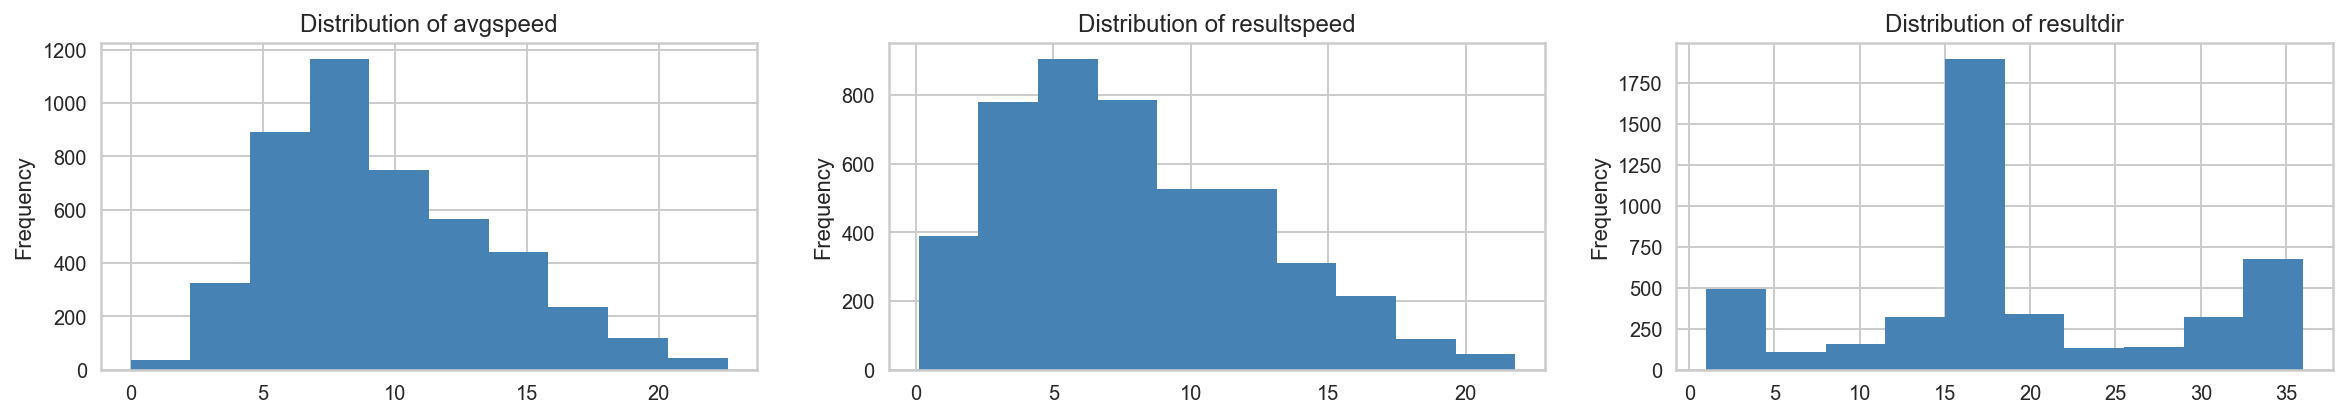

In [35]:
fig, ax =plt.subplots(1,3, figsize=(20,3))
str33.avgspeed.plot(kind="hist", ax = ax[0],  title="Distribution of avgspeed",color="steelblue")
str33.resultspeed.plot(kind="hist", ax = ax[1],  title="Distribution of resultspeed",color="steelblue")
str33.resultdir.plot(kind="hist", ax = ax[2],  title="Distribution of resultdir",color="steelblue")

## Feature Preprocessing _ Store 33 item 44, and Store 33 item 92

In [97]:
#item 44
X_train_44=str33itm44.sample(frac=0.8,random_state=200) 
y_train_44 = X_train_44.units

X_test_44=str33itm44.drop(X_train_44.index)
y_test_44 = X_test_44.units

#item 92
X_train_92=str33itm92.sample(frac=0.8,random_state=200) 
y_train_92 = X_train_92.units

X_test_92=str33itm92.drop(X_train_92.index)  
y_test_92 = X_test_92.units

### Target encoding

We wrote a self-defined function to automatically do target encoding for categorical features in training and testing dataframe.

In [98]:
def target_encoding (df_train, df_test):
    '''
    This function takes train and test datframe, and performs target encoding. 
    '''
    #calculate the mean for each variable in test dataset
    weekday_lib = df_train.groupby("weekday")["units"].mean().to_dict()
    weekday_lib["mean"] =  np.array(list(weekday_lib.values())).mean()
    codesum_lib = df_train.groupby("codesum")["units"].mean().to_dict()
    codesum_lib["mean"] =  np.array(list(codesum_lib.values())).mean()
    Season_lib = df_train.groupby("Season")["units"].mean().to_dict()
    Season_lib["mean"] =  np.array(list(Season_lib.values())).mean()
    month_lib = df_train.groupby("month")["units"].mean().to_dict()
    month_lib["mean"] =  np.array(list(month_lib.values())).mean()

    # recreate mean for train data 
    df_train["weekday_te"] = df_train.weekday.apply(lambda x: weekday_lib[x])
    df_train["codesum_te"] = df_train.codesum.apply(lambda x: codesum_lib[x])
    df_train["Season_te"] = df_train.Season.apply(lambda x: Season_lib[x])
    df_train["month_te"] = df_train.month.apply(lambda x: month_lib[x])

    # create mean for test data using historical averages
    df_test["weekday_te"] = df_test.weekday.apply(lambda x: weekday_lib[x] if (x in weekday_lib) else weekday_lib["mean"] )
    df_test["codesum_te"] = df_test.codesum.apply(lambda x: codesum_lib[x] if (x in codesum_lib) else codesum_lib["mean"] )
    df_test["Season_te"] = df_test.Season.apply(lambda x: Season_lib[x] if (x in Season_lib) else Season_lib["mean"] )
    df_test["month_te"] = df_test.month.apply(lambda x: month_lib[x] if (x in month_lib) else month_lib["mean"] )
    

In [99]:
target_encoding (X_train_44, X_test_44)
target_encoding (X_train_92, X_test_92)

### Binary targets transformation

We wrote a self-defined function to automatically do binary targest transformation

In [100]:
def binary_transformation(df_train, df_test): 
    '''
    This function takes train and test datframe and perfomrs binary tranformation.
    '''
    lb = preprocessing.LabelBinarizer()
    df_train['holidays_lb'] = lb.fit_transform(df_train['holidays'])
    df_test['holidays_lb'] = lb.fit_transform(df_test['holidays'])
    df_train['pre_holidays_lb'] = lb.fit_transform(df_train['pre_holidays'])
    df_test['pre_holidays_lb'] = lb.fit_transform(df_test['pre_holidays'])

In [101]:
binary_transformation(X_train_44, X_test_44)
binary_transformation(X_train_92, X_test_92)

### Tree-based feature selection

Not all variables are relevant to sales units, and irrelevant features would hurt models' performances.
Therefore, we wrote a self-defined function utilize tree baesd classifier to automatically select relevant features. 

#### Notice that for different input items, important features would be differnt. Therefore different features are selected for item 44 and item 92

In [178]:
def feature_selection(X_train, y_train, X_test, y_test):
    
    #First select the "vallid features" (exclude item_id, store_id, y_label...,etc.)
    features = ['tmax', 'tmin','tavg','depart','dewpoint','wetbulb',
            'heat','cool','sunrise','sunset','snowfall','preciptotal',
            'stnpressure','sealevel','resultspeed','resultdir','avgspeed',
            'holidays_lb','pre_holidays_lb','weekend','month','weekday_te', 
            'codesum_te', 'Season_te', 'month_te']
    
    X_train_raw = X_train[features]
    X_test_raw = X_test[features]
    X_train_name = list(X_train_raw.columns)
    
    #Then utilize ExtraTreesClassifier to select the relevant features
    clf = ExtraTreesClassifier(n_estimators=100)
    clf = clf.fit(X_train_raw, y_train)
    
    model = SelectFromModel(clf, prefit=True)
    X_train_sl = model.transform(X_train_raw)
    X_test_sl = model.transform(X_test_raw)
    
    retained_names = [X_train_name[i] for i in range(len(X_train_name)) if  X_train_raw.iloc[1][i] in X_train_sl[1]]
    
    #Print out important features
    print("Top 5 Important features: ")
    count = 1
    for feature, name in sorted(zip(clf.feature_importances_,X_train_name),reverse=True)[:5]:
        print(f"Top {count} important features: {name, feature}")
        count+=1

    plt.plot(X_train_name,clf.feature_importances_)
    plt.title("Feature Importances")
    plt.xticks(rotation=90)
    
    
    return (X_train_sl,y_train, X_test_sl, y_test,retained_names)

Top 5 Important features: 
Top 1 important features: ('stnpressure', 0.05949944366630713)
Top 2 important features: ('resultspeed', 0.05793839516417508)
Top 3 important features: ('avgspeed', 0.05745755029103721)
Top 4 important features: ('sealevel', 0.056651576904070404)
Top 5 important features: ('depart', 0.05656113383382661)


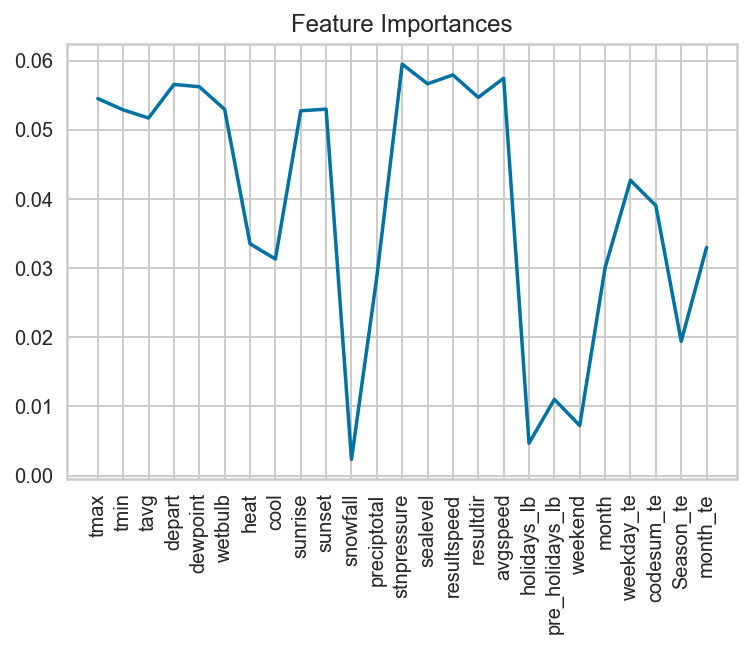

In [179]:
X_train_44_sl, y_train_44, X_test_44_sl,y_test_44, retained_names_44 = feature_selection(X_train_44, y_train_44, X_test_44, y_test_44)

Top 5 Important features: 
Top 1 important features: ('month_te', 0.09133052207853826)
Top 2 important features: ('Season_te', 0.08275114727521365)
Top 3 important features: ('sunrise', 0.05779209496742726)
Top 4 important features: ('sunset', 0.055919060612889926)
Top 5 important features: ('dewpoint', 0.051177539799021815)


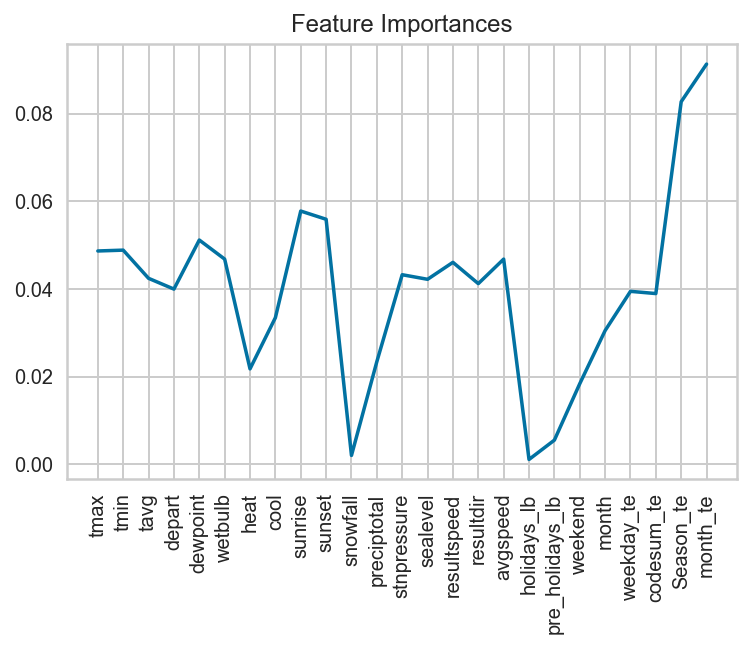

In [180]:
X_train_92_sl, y_train_92, X_test_92_sl,y_test_92, retained_names_92 = feature_selection(X_train_92, y_train_92, X_test_92, y_test_92)

### Scaling Features: Robust Scaler

We choose to use robust scaler because this scaling method has two advantages:
1. Not assume our data is normally distributed within each feature
2. Insensitive to outliers

For reuse simplicity, we also wrote a function for scaling the features.

In [181]:
def robust_scaler(X_train, X_test):
    robustScaler = RobustScaler() 
    # fit and tranform the training data
    X_train_new = robustScaler.fit_transform(X_train) 
    # tranform test data
    X_test_new = robustScaler.transform(X_test) 
    return (X_train_new,X_test_new)

In [134]:
X_train_44_fin, X_test_44_fin  = robust_scaler(X_train_44_sl, X_test_44_sl)

In [135]:
X_train_92_fin, X_test_92_fin  = robust_scaler(X_train_92_sl, X_test_92_sl)

### Helper function: Performance Matrix

In [47]:
def evaluate_performances(y_test, y_pred):
    '''
    A helper function to evaluate model performance.
    '''
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

## Linear Regression_item 44_based on our selected feature

In [48]:
x_train = X_train_44[["weekday_te", "tavg", 'depart', 'heat', 'cool',  'resultdir','holidays', 'pre_holidays',  'weekend']]
y_train = y_train_44
x_test = X_test_44[["weekday_te", "tavg", 'depart',  'heat', 'cool',  'resultdir', 'holidays', 'pre_holidays',  'weekend']]
y_test = y_test_44

lr = LinearRegression()
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

evaluate_performances(y_test, predictions)

print(lr.intercept_)
print(lr.coef_)

Mean Absolute Error: 37.674050663917434
Mean Squared Error: 2656.949132436912
Root Mean Squared Error: 51.54560245488369
-18.476693012989386
[  0.99867088   0.065042    -0.29209815   0.4598726    0.78425917
   0.27475982 -14.88120456  22.17370735  -1.60116803]


In [49]:
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df_pred.head()

Actual   Predicted
3595      354  255.219377
13363     178  182.857426
32899     230  225.070717
37783     233  235.793326
86623     145  175.926164

### Regularized the Linear Regression

In [50]:
ridge = Ridge(alpha = 1)
scores = cross_val_score(ridge, x_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(scores)
print("=======================")
print(scores.mean())

[-44.00451664 -45.63039215 -46.16055223 -51.41431484 -35.8994589
 -44.74661856 -46.41953845 -44.06957117 -37.77081592 -44.57276295]
-44.06885417964635


In [51]:
# search for an optimal value of alpha
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
mean_square_err = []
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    scores = cross_val_score(ridge, x_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    mean_square_err.append(scores.mean())
print(mean_square_err)

[-44.09582048197652, -44.095794672657206, -44.095536734748954, -44.09297277640634, -44.06885417964635, -43.9233493614363, -43.72149504505681, -43.69809025503683]


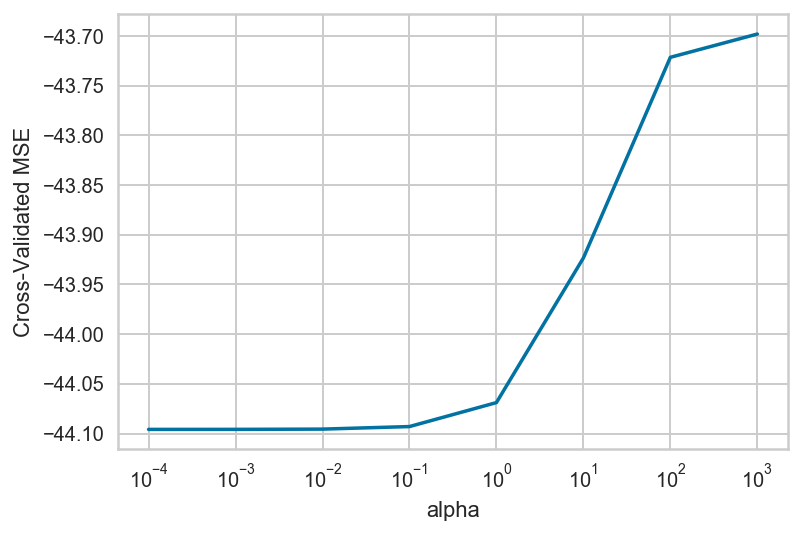

In [52]:
plt.semilogx(alphas, mean_square_err)
plt.xlabel('alpha')
plt.ylabel('Cross-Validated MSE')
plt.show()

In [53]:
#Refit the model based on the by hand cross-validation result
ridge = Ridge(alpha = 100)
ridge.fit(x_train, y_train)
rige_prediction = ridge.predict(x_test)
df_pred_ridge = pd.DataFrame({'Actual': y_test, 'Predicted': rige_prediction})

evaluate_performances(y_test, rige_prediction)

Mean Absolute Error: 38.159229559664915
Mean Squared Error: 2749.8141205629277
Root Mean Squared Error: 52.438670087664576


In [54]:
df_pred_ridge.head()

Actual   Predicted
3595      354  243.013634
13363     178  183.930334
32899     230  227.590779
37783     233  238.189363
86623     145  177.102795

### Visualize the standardized  model's prediction result

We created a self-defined function to draw line plot, box plot, area plot, and kde plot

In [131]:
def visualize_graph(df_pred):
    fig, axes = plt.subplots(2,2, figsize=(12,7))

    #Plot the result in line plot
    df_pred.plot(title="Actual vs. Predict result line plot",ax=axes[0, 0])

    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[0, 1])

    #Plot the area plot
    df_pred.plot.area(title="Actual vs. Predict result area plot",stacked=False,ax=axes[1,0])

    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[1,1])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


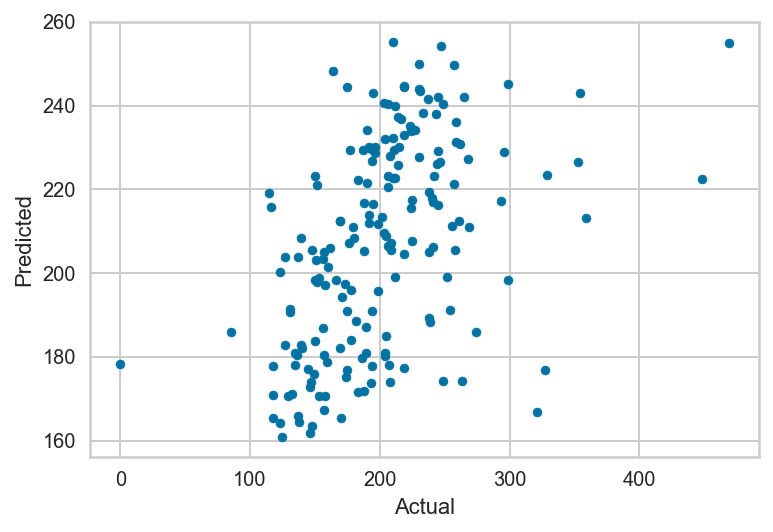

In [143]:
#Scatter plot to explore the relationship between actual points and predicted points
df_pred_ridge.plot.scatter(x='Actual',y='Predicted')

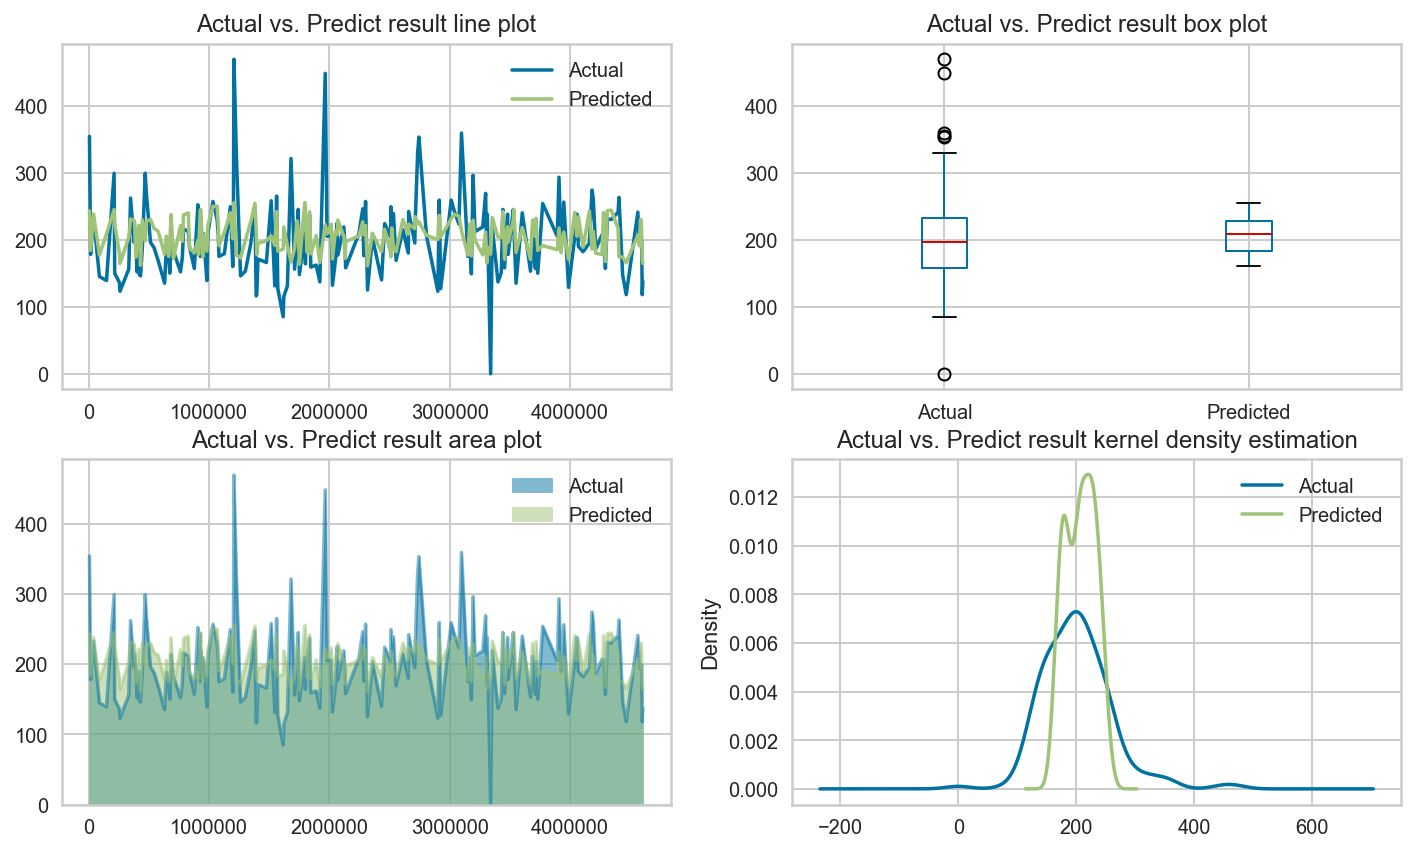

In [127]:
visualize_graph(df_pred_ridge)

Findings: 

1. The sales volume of item 44 is stable over time.

2. The model can accurately predict the long-term average sales volumes but can hardly predict the outlier situations. 

Ex. Rise demand of toilet paper because of the coronavirus


## Re-train item 44  on model selected  features

### GridSearch CV 

In [57]:
param_grid = {'alpha':[0.01,0.1, 1, 10, 100, 1000]}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=param_grid, scoring= 'explained_variance',cv=10, n_jobs=-2, return_train_score=True)

grid.fit(X_train_44_fin,y_train_44)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-2,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='explained_variance', verbose=0)

In [58]:
pd.DataFrame(grid.cv_results_).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.005485      0.002999         0.001097        0.000299        0.01   
1       0.001796      0.000399         0.001197        0.000747         0.1   
2       0.001695      0.000457         0.000698        0.000457           1   
3       0.001597      0.000488         0.000697        0.000456          10   
4       0.001497      0.000499         0.000797        0.000399         100   

            params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.01}           0.063080           0.087098           0.060711   
1   {'alpha': 0.1}           0.083508           0.087636           0.056820   
2     {'alpha': 1}           0.133938           0.091185           0.029361   
3    {'alpha': 10}           0.137398           0.099627          -0.040029   
4   {'alpha': 100}           0.109699           0.086219          -0.049691   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
0           0.183967           0.255963           0.042398           0.051258   
1           0.183480           0.256490           0.042150           0.050893   
2           0.180031           0.259684           0.040748           0.048914   
3           0.169901           0.262076           0.040738           0.051605   
4           0.130108           0.201603           0.036047           0.062865   

   split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
0           0.217521           0.097756           0.036517         0.109627   
1           0.218058           0.097450           0.036913         0.111340   
2           0.220593           0.095555           0.040273         0.114028   
3           0.215648           0.094749           0.053592         0.108530   
4           0.155665           0.080240           0.067934         0.088069   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.075539                3            0.150312            0.152614   
1        0.074929                2            0.150170            0.152597   
2        0.077721                1            0.147397            0.151839   
3        0.085349                4            0.142263            0.147147   
4        0.065179                5            0.115923            0.119566   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.146941            0.139374            0.140927   
1            0.146932            0.139362            0.140911   
2            0.146529            0.138883            0.140225   
3            0.143853            0.135934            0.135945   
4            0.117383            0.110033            0.110008   

   split5_train_score  split6_train_score  split7_train_score  \
0            0.155756            0.157588            0.136575   
1            0.155744            0.157577            0.136555   
2            0.155234            0.157102            0.135716   
3            0.151743            0.153722            0.131213   
4            0.124574            0.124570            0.106459   

   split8_train_score  split9_train_score  mean_train_score  std_train_score  
0            0.150926            0.157300          0.148831         0.007232  
1            0.150914            0.157284          0.148805         0.007230  
2            0.150375            0.156602          0.147990         0.007256  
3            0.146847            0.152105          0.144077         0.007312  
4            0.119289            0.122948          0.117075         0.006096

In [59]:
print(f'Best Scores: {grid.best_score_}, Best params for alpha: {grid.best_params_}')

Best Scores: 0.11402811551959972, Best params for alpha: {'alpha': 1}


In [60]:
linear_grid_predict = grid.predict(X_test_44_fin)
df_pred = pd.DataFrame({'Actual': y_test_44, 'Predicted': linear_grid_predict})

#Evaluate the model's performances
evaluate_performances(y_test_44, linear_grid_predict)

Mean Absolute Error: 39.752412405395354
Mean Squared Error: 3021.6954941537583
Root Mean Squared Error: 54.96995082910079


### Visualize the automatic selection outcome

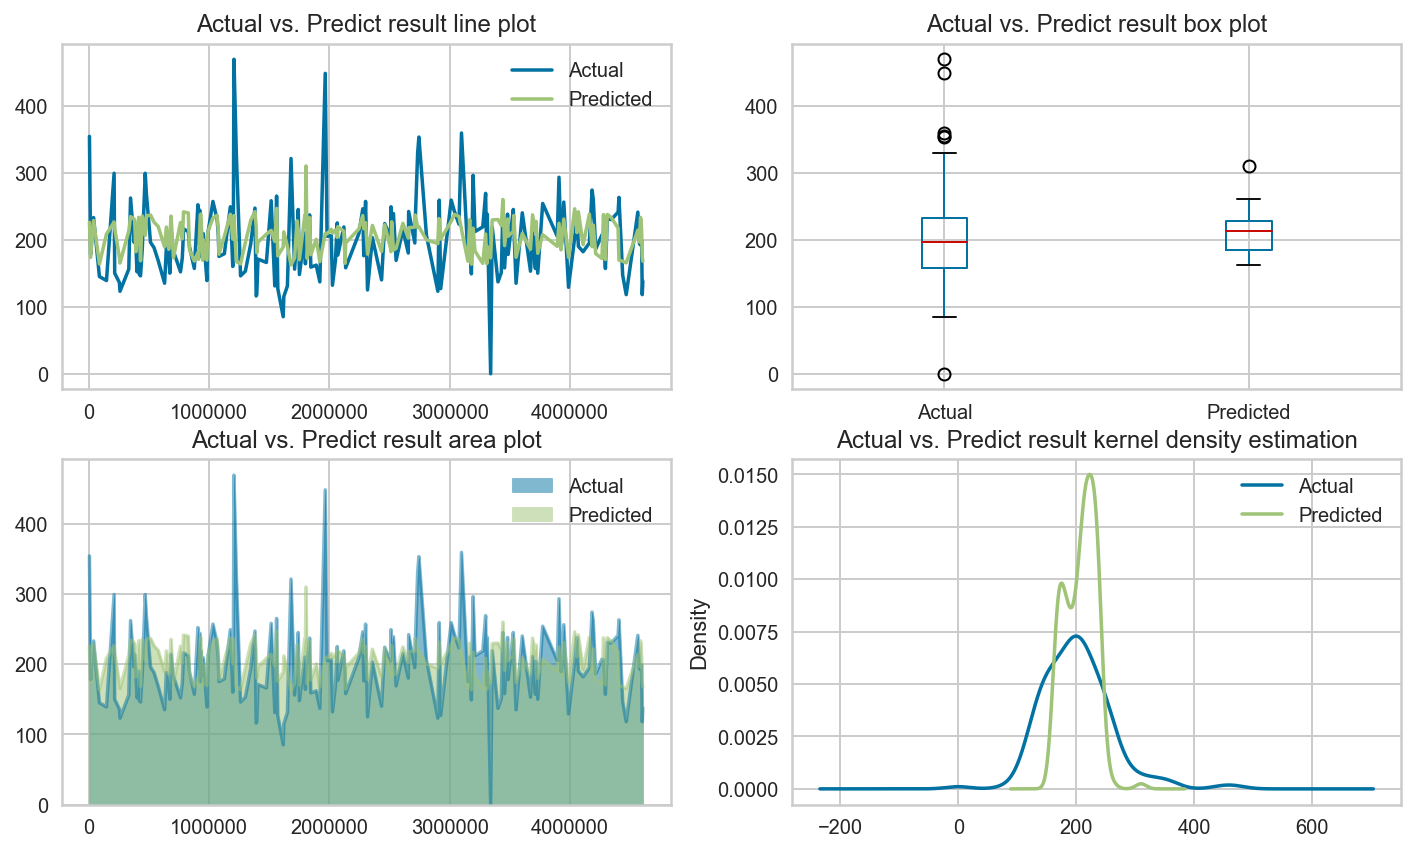

In [61]:
visualize_graph(df_pred)

## Linear regression- item 92 (Based on Grid Search)

Mean Absolute Error: 0.8263606377301744
Mean Squared Error: 1.8724100611708152
Root Mean Squared Error: 1.3683603550128216


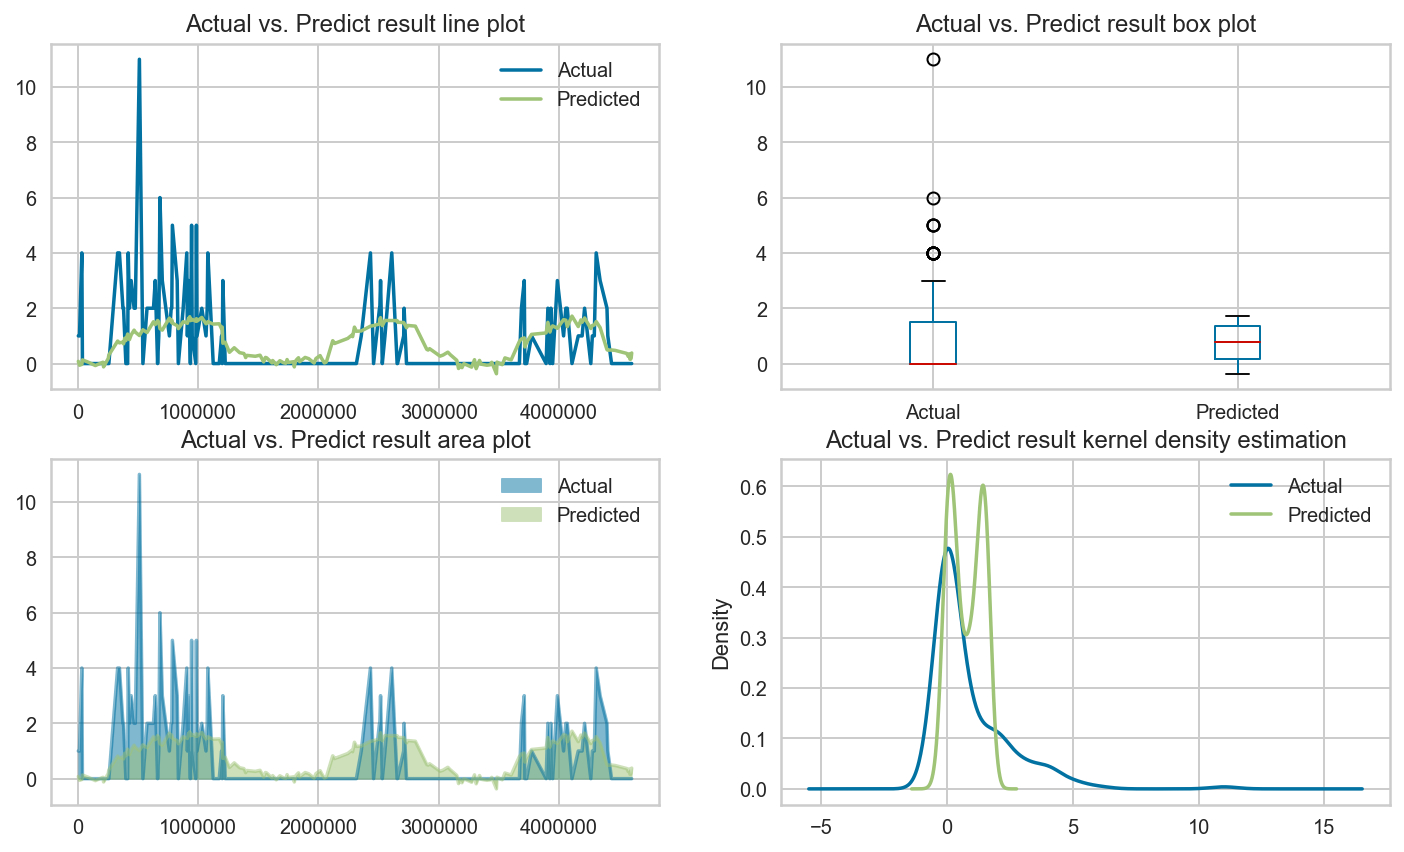

In [62]:
param_grid = {'alpha':[0.01,0.1, 1, 10, 100, 1000]}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=param_grid, scoring= 'explained_variance',cv=10, n_jobs=-2, return_train_score=True)

grid.fit(X_train_92_fin,y_train_92)
linear_grid_predict = grid.predict(X_test_92_fin)
df_pred_lr_92 = pd.DataFrame({'Actual': y_test_92, 'Predicted': linear_grid_predict})

#Evaluate the model's performances
evaluate_performances(y_test_92, linear_grid_predict)
visualize_graph(df_pred_lr_92)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


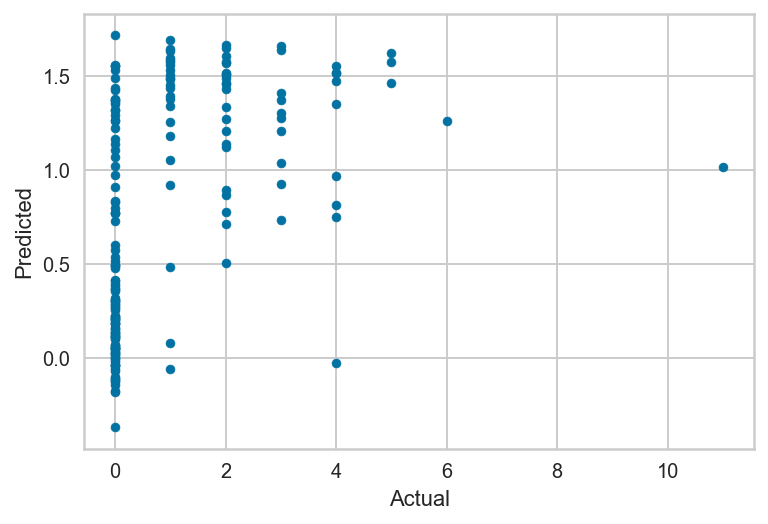

In [144]:
#Scatter plot to explore the relationship between actual points and predicted points
df_pred_lr_92.plot.scatter(x='Actual',y='Predicted')

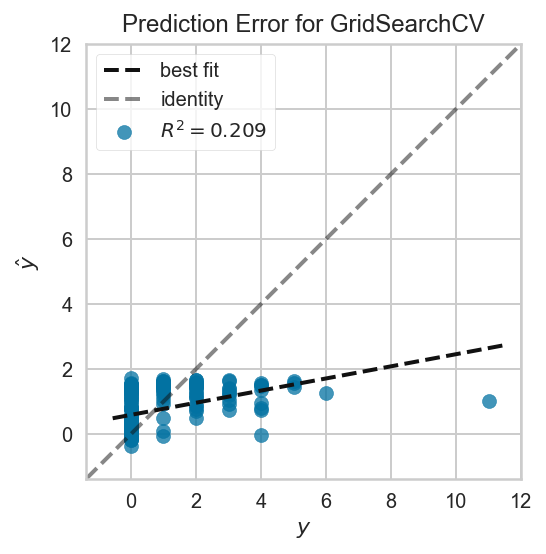

In [63]:
visualizer = PredictionError(grid)
visualizer.fit(X_train_92_fin, y_train_92)  # Fit the training data to the visualizer
visualizer.score(X_test_92_fin, y_test_92)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

Findings: 

1. The sales volume of item 92 is highly volatile over time. We guess this product may be a seasonal product.
2.  Linear regression has less predictive power over high-volatile time-series data. The result is less accurate compared to the prediction result of item 44.


# KNN - item 44

Use kNN model to fit the training data, and predict the value of the test data.



In [145]:
# instantiate the Regressor
kNN = KNeighborsRegressor()
kNN.fit(X_train_44_fin, y_train_44)
knn_predict = kNN.predict(X_test_44_fin)
knn_pred = pd.DataFrame({'Actual': y_test_44, 'Predicted': knn_predict})
knn_pred.head()

Actual  Predicted
3595      354      214.8
13363     178      151.8
32899     230      237.0
37783     233      174.4
86623     145      166.4

In [146]:
#Evaluate the model's performances
evaluate_performances(y_test_44, knn_predict)

Mean Absolute Error: 46.21420765027323
Mean Squared Error: 3734.343606557378
Root Mean Squared Error: 61.10927594528819


### Visualize the KNN selection outcome

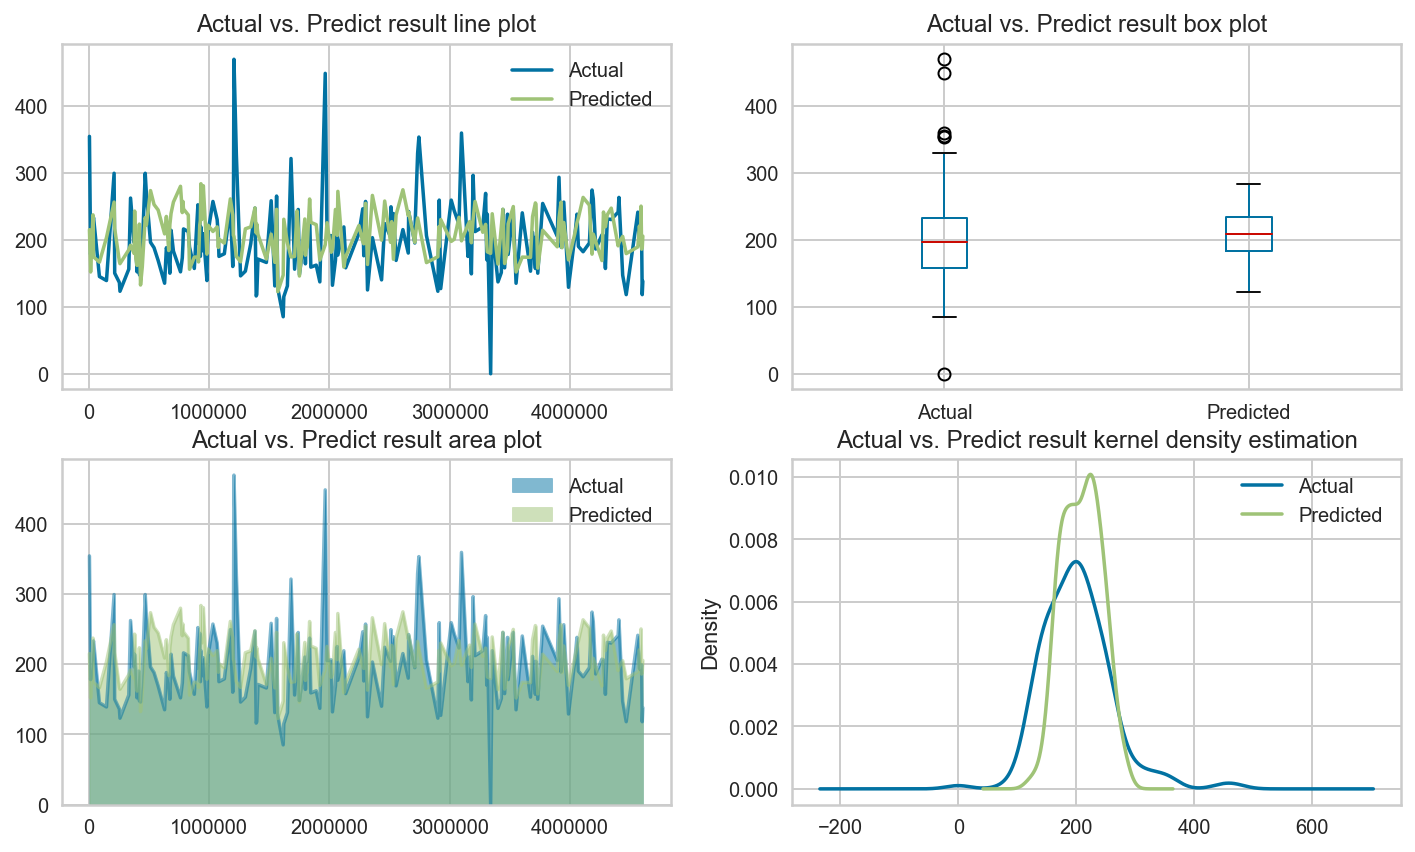

In [147]:
visualize_graph(knn_pred)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


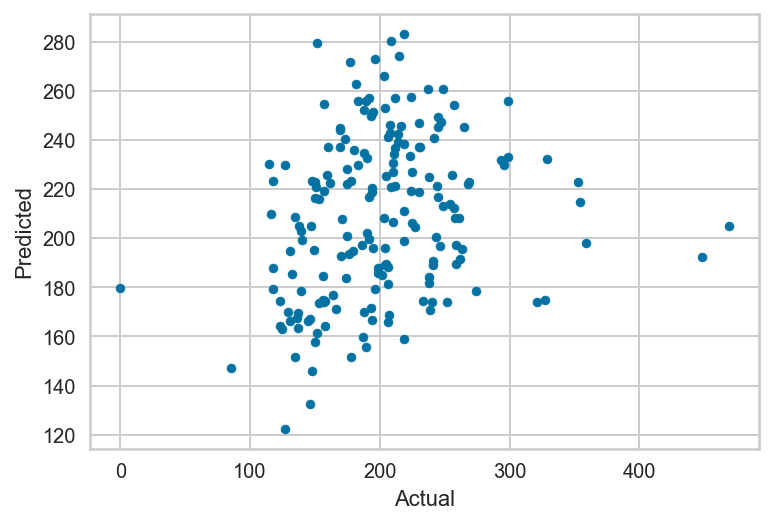

In [148]:
#Scatter plot to explore the relationship between actual points and predicted points
knn_pred.plot.scatter(x='Actual',y='Predicted')

In [67]:
#the coefficient of determination R^2 of the knn prediction.
kNN.score(X_test_44_fin, y_test_44)

-0.07599602734890443

The result of un-tuned knn prediction is slightly worse than our base model. 

### Tune KNN via GridSearch CV

Since it took too long to run and couldn't get back the result. We may need to refine the optimization part.

In [68]:
knn= KNeighborsRegressor()
k_range= np.arange(2,50)
param_grid=dict(n_neighbors=k_range)
grid_knn= GridSearchCV(estimator = knn, param_grid = param_grid)
grid_knn.fit(X_train_44_fin, y_train_44)
print(f"Best params: {grid_knn.best_params_}")

#Refit the model
knn = grid_knn.best_estimator_
y_pred_knn = knn.predict(X_test_44_fin)
knn_pred = pd.DataFrame({'Actual': y_test_44, 'Predicted': y_pred_knn})

Best params: {'n_neighbors': 49}


In [69]:
knn_pred.head()

Actual   Predicted
3595      354  206.204082
13363     178  203.959184
32899     230  221.489796
37783     233  221.183673
86623     145  192.897959

In [70]:
#Evaluate the model's performances
evaluate_performances(y_test_44, y_pred_knn)

Mean Absolute Error: 41.33478309356529
Mean Squared Error: 3229.8683904475142
Root Mean Squared Error: 56.83193108145732


### Visualize the tuning KNN prediction outcome

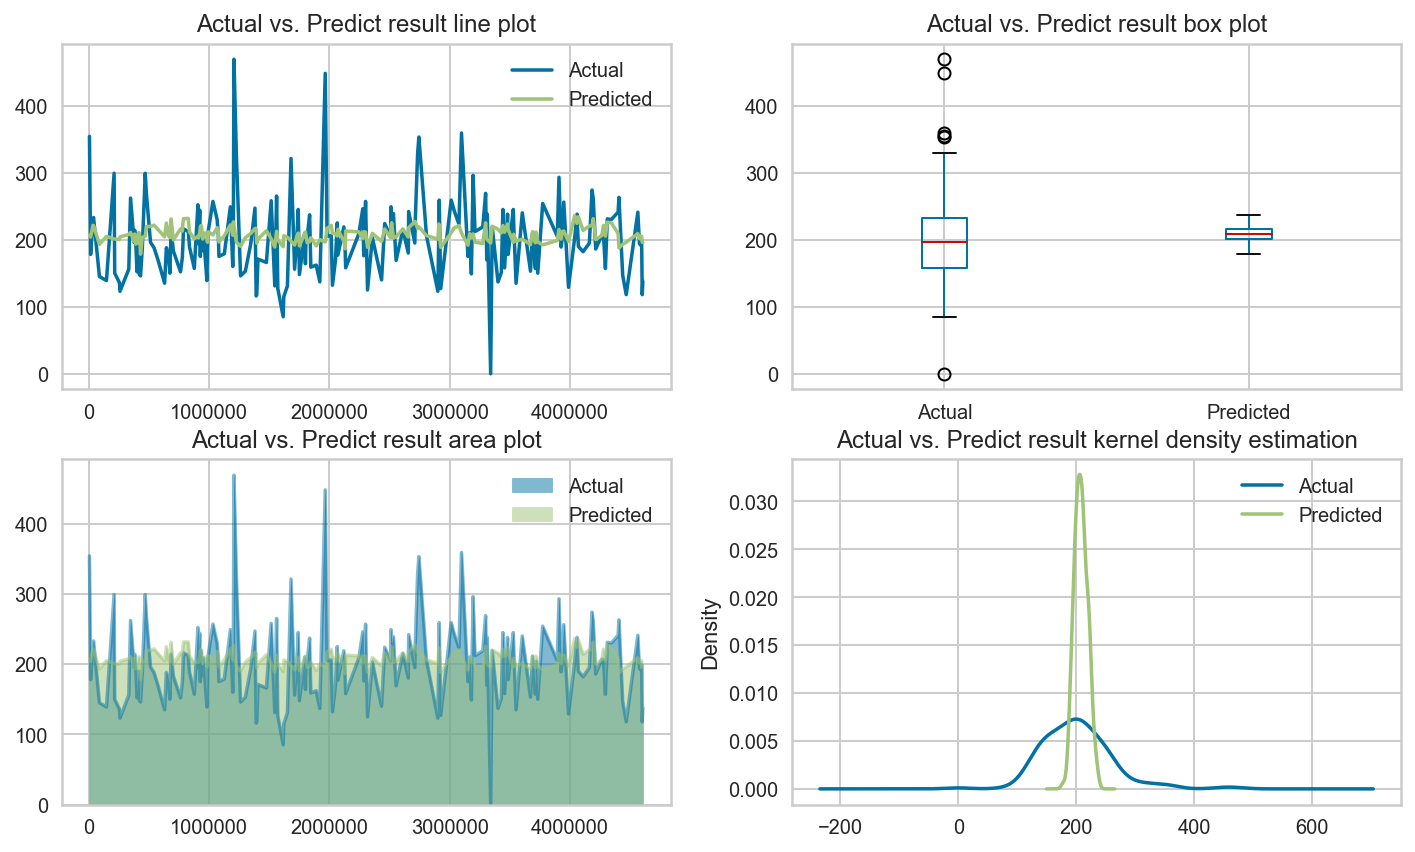

In [71]:
visualize_graph(knn_pred)

In [72]:
#the coefficient of determination R^2 of the knn prediction.
knn.score(X_test_44_fin, y_test_44)

0.06936106498642114

Improve the prediciton result after tuning the kNN model. The original oefficient of determination R^2 of the knn prediction was -0.075. With GridSearch CV, the score rises up to 0.069.However, the model is a little bit overgeneralized the situation. The model could hardly predict the sales unit in terms of daily average.

# KNN - Item 92

In [149]:
knn= KNeighborsRegressor()
k_range= np.arange(2,80)
param_grid=dict(n_neighbors=k_range)
grid_knn= GridSearchCV(estimator = knn, param_grid = param_grid)
grid_knn.fit(X_train_92_fin, y_train_92)
print(f"Best params: {grid_knn.best_params_}")

#Refit the model
knn = grid_knn.best_estimator_
y_pred_knn = knn.predict(X_test_92_fin)
knn_pred = pd.DataFrame({'Actual': y_test_92, 'Predicted': y_pred_knn})

Best params: {'n_neighbors': 40}


In [150]:
#Evaluate the model's performances
evaluate_performances(y_test_92, y_pred_knn)

Mean Absolute Error: 0.8120218579234972
Mean Squared Error: 1.9105464480874317
Root Mean Squared Error: 1.3822251799498633


### Visualize the tuning KNN prediction outcome - item 92

Notice that item 92 is easier to be affacted by weather features. 
This result is corresponding to our EDA result.

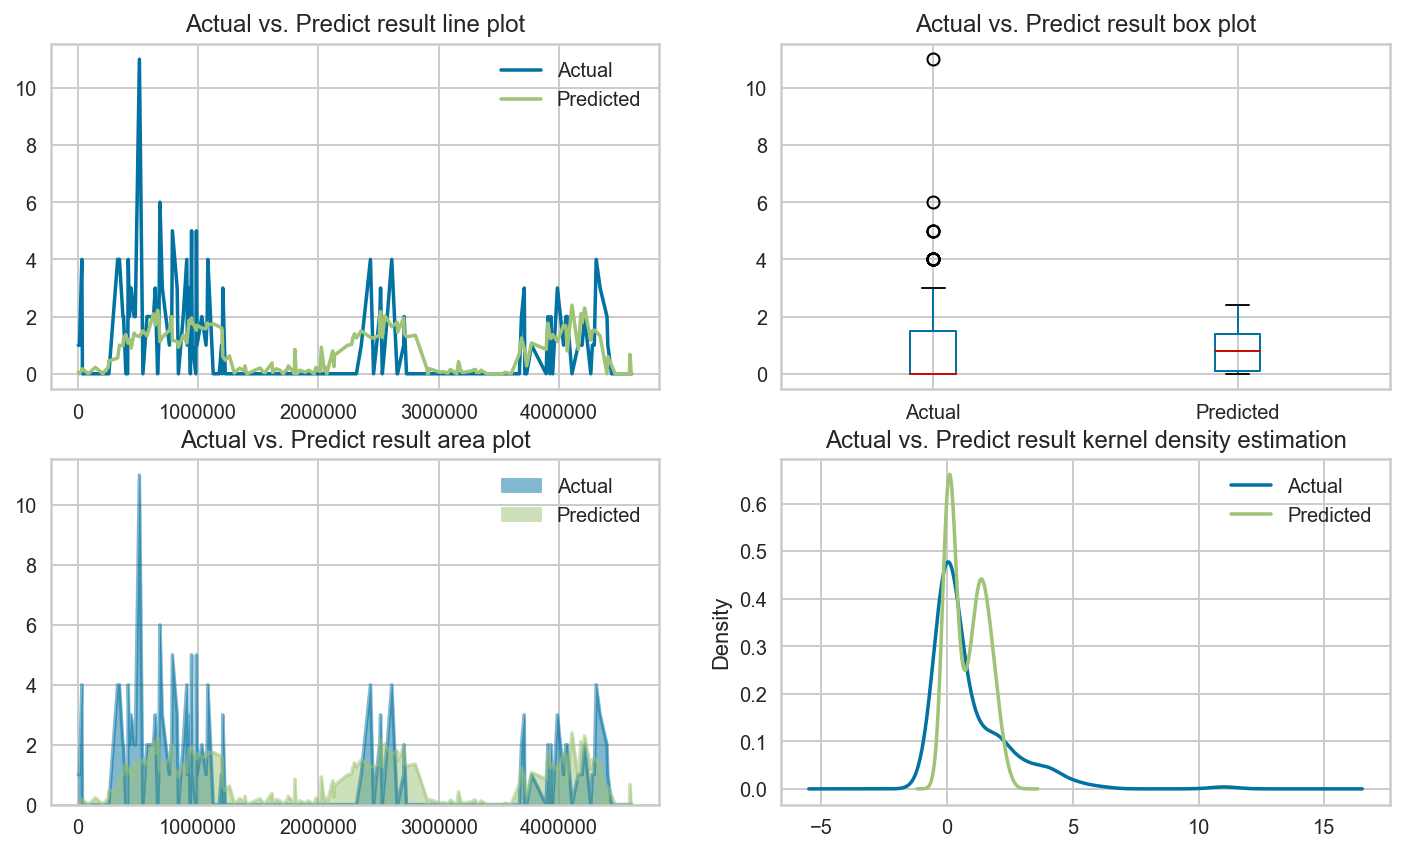

In [151]:
visualize_graph(knn_pred)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


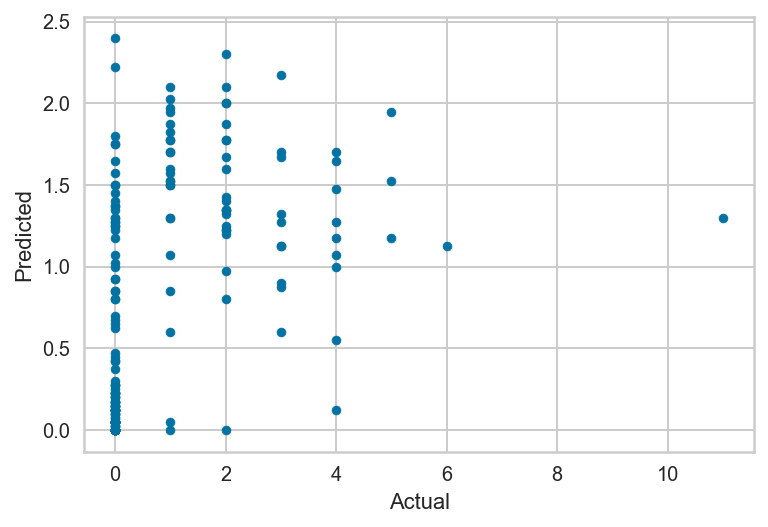

In [152]:
#Scatter plot to explore the relationship between actual points and predicted points
knn_pred.plot.scatter(x='Actual',y='Predicted')

In [153]:
#the coefficient of determination R^2 of the knn prediction.
grid_knn.score(X_test_92_fin, y_test_92)

0.18354528749712895

KNN has higher prediction power over un-patterned data. KNN obviously performs better on item 92 compared to item 44.
The R^2 of the knn prediction on item 92 is 0.18. This result is higher than the prediction score on item 44.

# Random Forest - item 44

In [76]:
rf = RandomForestRegressor(n_estimators= 100, random_state=42)
rf.fit(X_train_44_fin, y_train_44)
rf_pred= rf.predict(X_test_44_fin)
#Evaluate the model's performances
evaluate_performances(y_test_44, rf_pred)

Mean Absolute Error: 43.21486338797814
Mean Squared Error: 3249.8981726775955
Root Mean Squared Error: 57.00787816326438


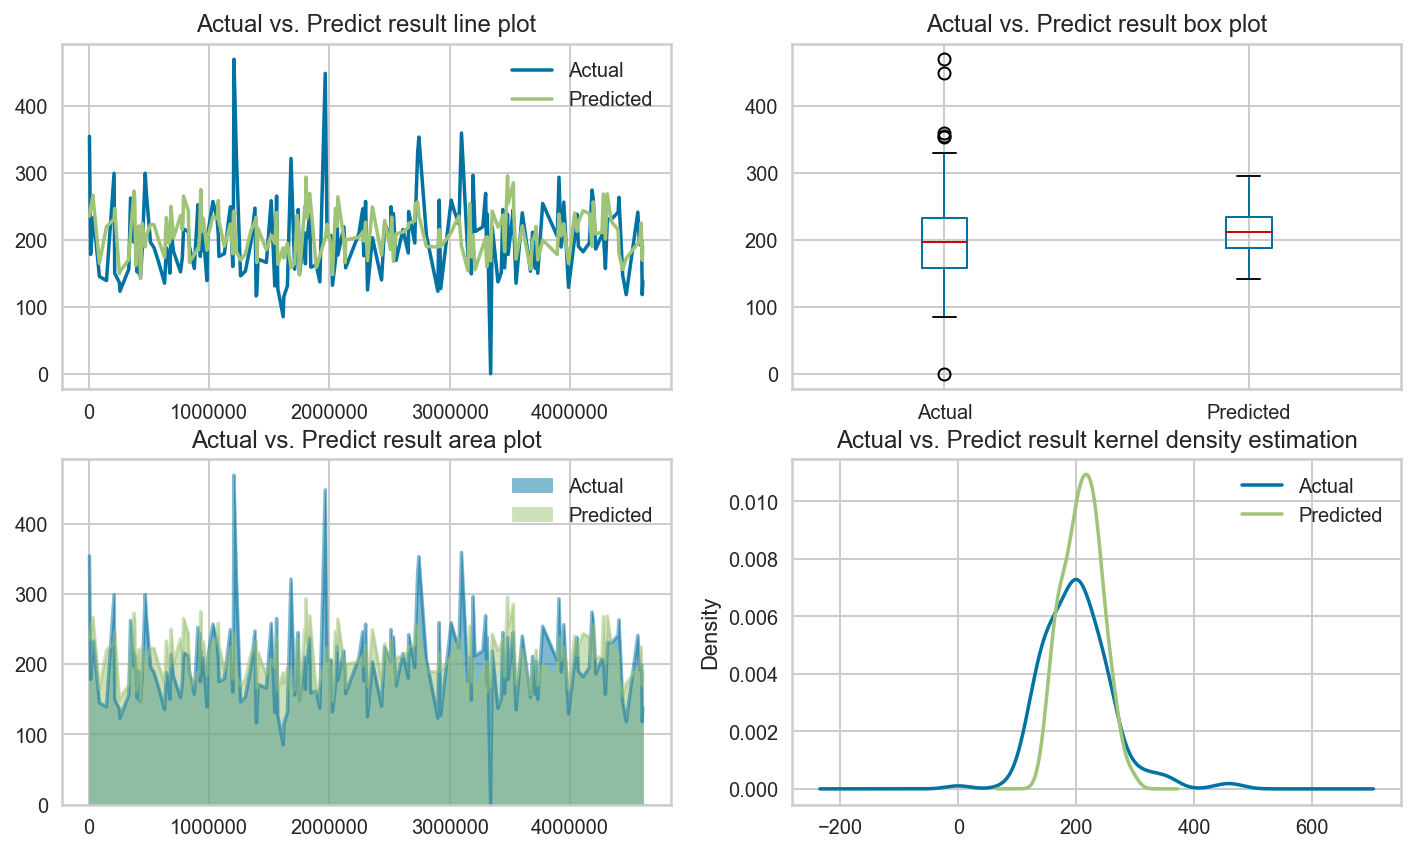

In [77]:
rf_pred_df = pd.DataFrame({'Actual': y_test_44, 'Predicted': rf_pred})
visualize_graph(rf_pred_df)

# Tuning Random Forests - item 44

To further optimized our model, we adopted grid search cv to find possible optimal parameters and retrain the random forest model.

In [154]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 80, 90, 100],
    'max_features': [2, 3, 5],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [8, 10, 12],
}

rf_tuned = RandomForestRegressor()

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf_tuned, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train_44_fin, y_train_44)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   14.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [155]:
print (grid_search_rf.best_params_)

{'bootstrap': True, 'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [156]:
best_grid_rf = grid_search_rf.best_estimator_

rf_grid_predictions = best_grid_rf.predict(X_test_44_fin)
rf_grid_errors = abs(rf_grid_predictions - y_test_44)

evaluate_performances(y_test_44, rf_grid_predictions)

Mean Absolute Error: 41.04868009991995
Mean Squared Error: 3027.9973595505594
Root Mean Squared Error: 55.02724197659337


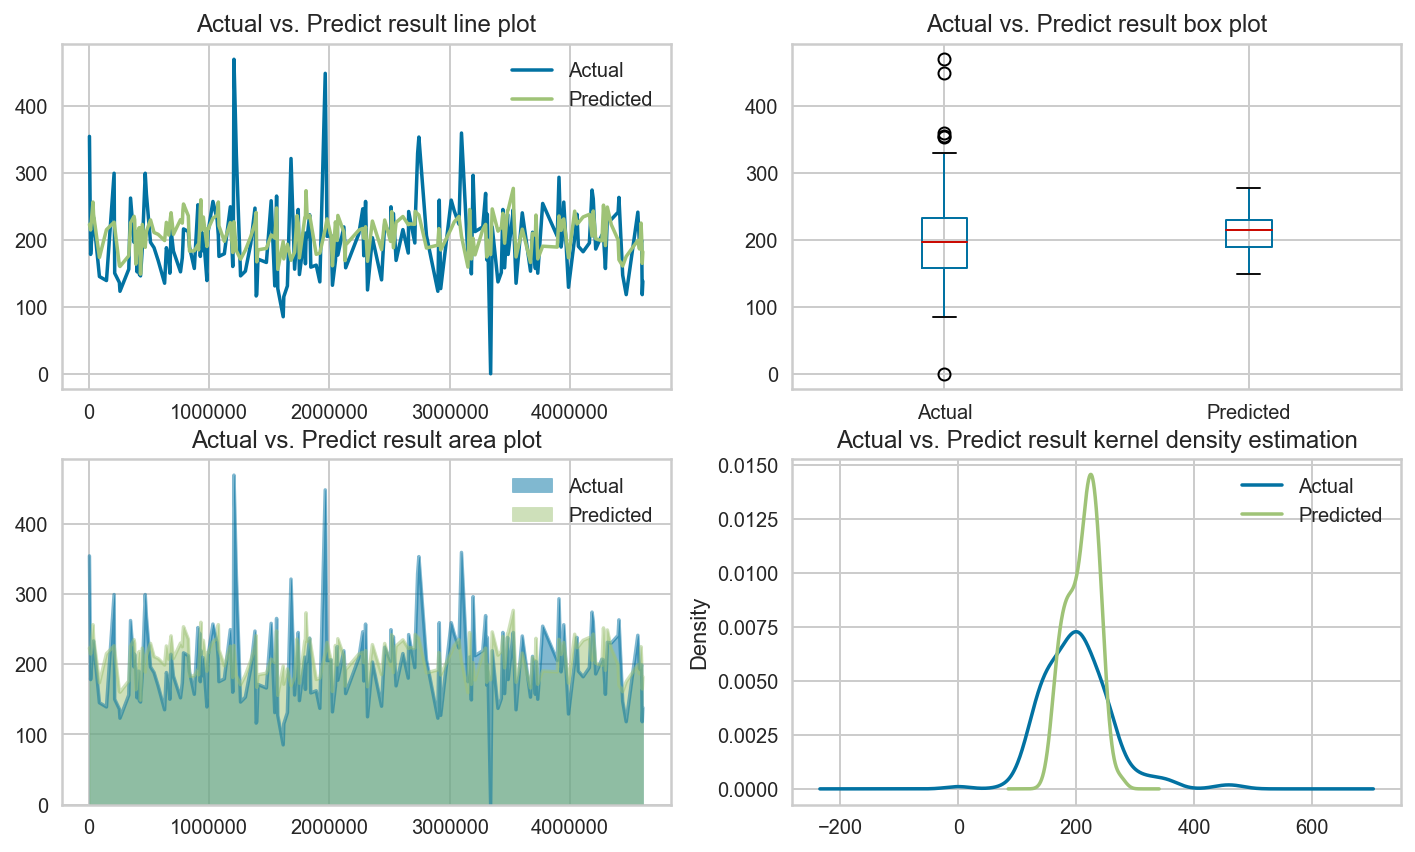

In [157]:
rf_pred_df_2 = pd.DataFrame({'Actual': y_test_44, 'Predicted': rf_grid_predictions})
visualize_graph(rf_pred_df_2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


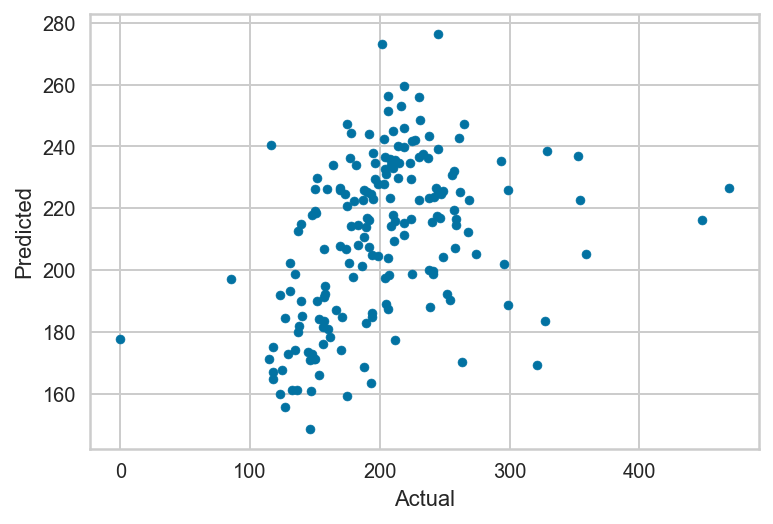

In [158]:
#Scatter plot to explore the relationship between actual points and predicted points
rf_pred_df_2.plot.scatter(x='Actual',y='Predicted')

In [159]:
# Get feature importances
importances = list(best_grid_rf.feature_importances_)
feature_list = retained_names_44
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: weekday_te Importance: 0.216
Variable: sunrise Importance: 0.11
Variable: sunset Importance: 0.086
Variable: tmax Importance: 0.063
Variable: depart Importance: 0.062
Variable: resultspeed Importance: 0.062
Variable: avgspeed Importance: 0.057
Variable: stnpressure Importance: 0.054
Variable: sealevel Importance: 0.054
Variable: tavg Importance: 0.051
Variable: tmin Importance: 0.049
Variable: resultdir Importance: 0.047
Variable: wetbulb Importance: 0.045
Variable: dewpoint Importance: 0.043


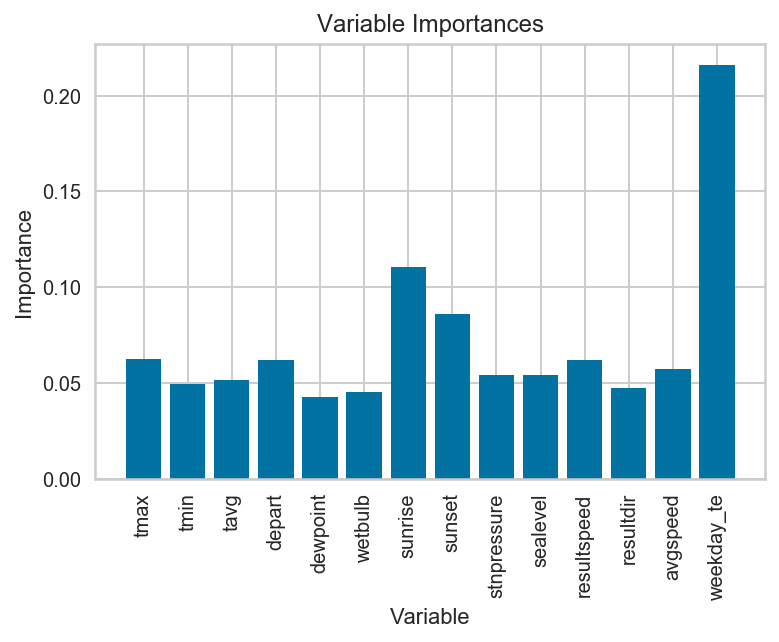

In [160]:
#Visualize the variable importances
# plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances'); 

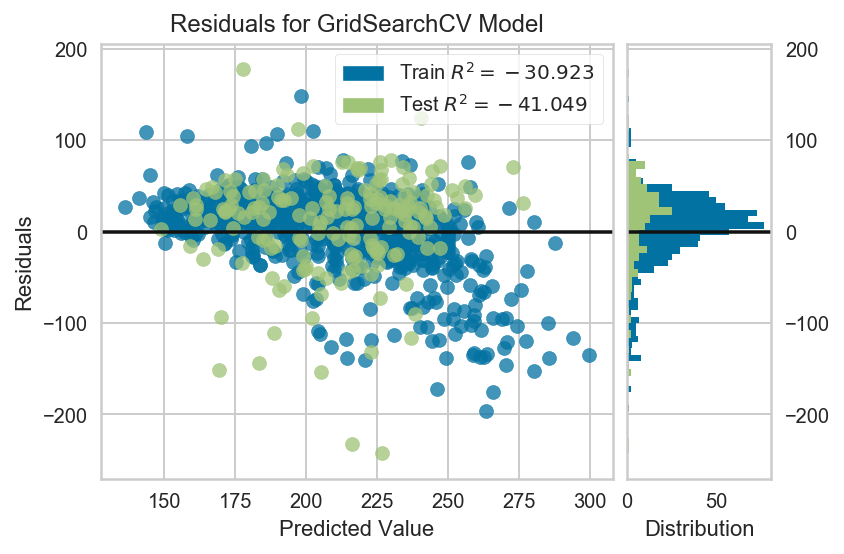

In [161]:
viz_rf_44 = residuals_plot(grid_search_rf, X_train_44_fin, y_train_44, X_test_44_fin, y_test_44)

Random forest gives us the most accuarte result, therefore we pick random forest as our best model. <br>

 <b>Random forst (item 44) : </b><br>
Mean Absolute Error: 41.04868009991995 <br>
Mean Squared Error: 3027.9973595505594 <br>
Root Mean Squared Error: 55.02724197659337 <br>

 <b>Our findings : </b><br>

1. Item 44 is a  high demand product sold on weekdays. It may be coffee, breads, or some snacks. 

2. Item 44 has higher demand on morning(sunrise) getting on the work and evening  (sunset) getting off the work.

<b>TOP 3 most important features: </b><br>

Variable 1: weekday    Importance: 0.21<br>

Variable 2: sunrise    Importance: 0.11<br>

Variable 3: sunset     Importance: 0.086<br>


# Random Forests - item 92

In [162]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 80, 90, 100],
    'max_features': [2, 3, 5],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [8, 10, 12],
}

rf_tuned = RandomForestRegressor()

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf_tuned, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train_92_fin, y_train_92)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   12.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [163]:
print (grid_search_rf.best_params_)

{'bootstrap': True, 'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 8}


In [164]:
best_grid_rf = grid_search_rf.best_estimator_

rf_grid_predictions = best_grid_rf.predict(X_test_92_fin)
rf_grid_errors = abs(rf_grid_predictions - y_test_92)

evaluate_performances(y_test_92, rf_grid_predictions)

Mean Absolute Error: 0.7407167804738924
Mean Squared Error: 1.76854229502818
Root Mean Squared Error: 1.3298655176476228


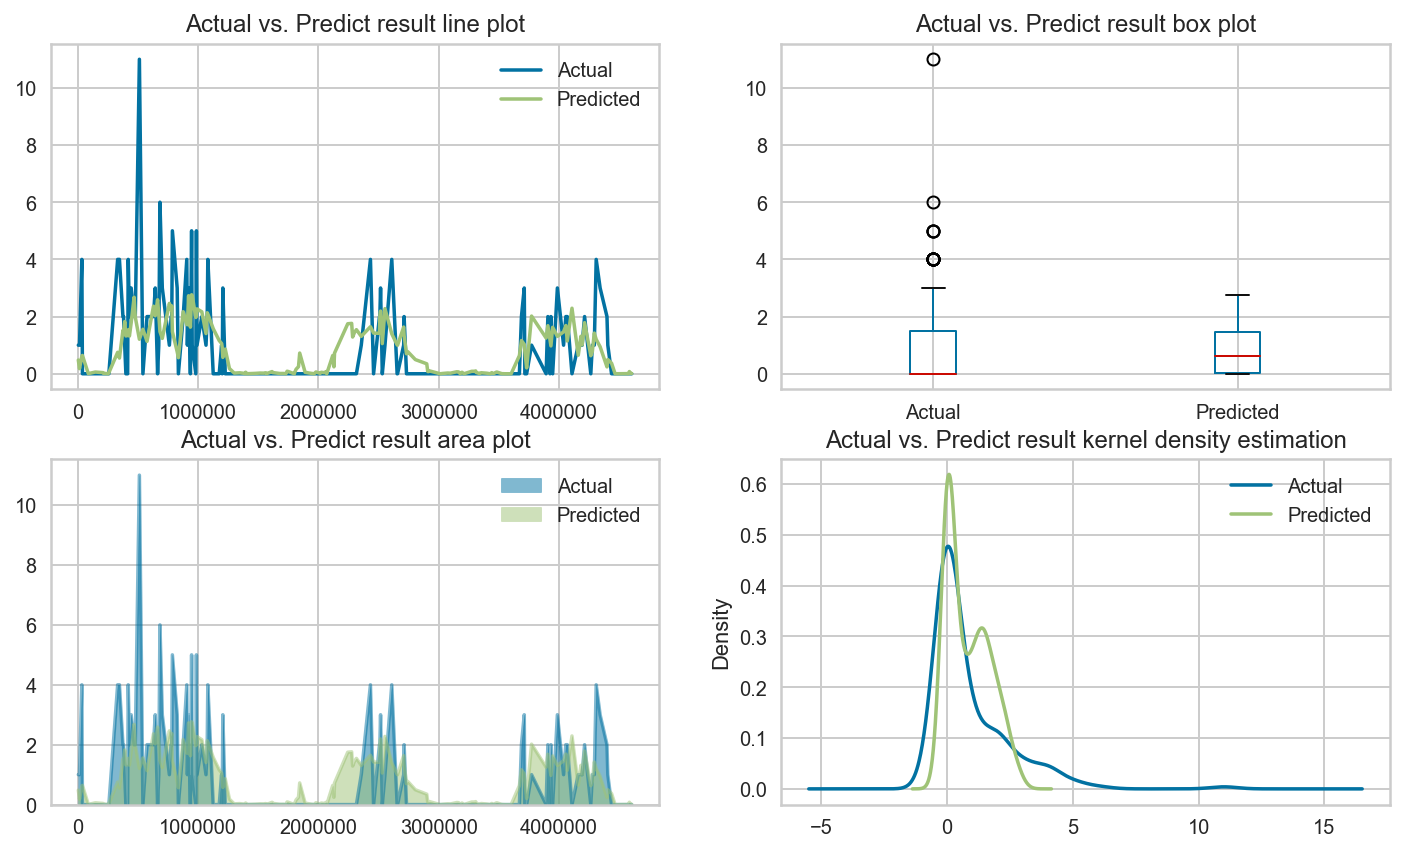

In [165]:
rf_pred_df_2 = pd.DataFrame({'Actual': y_test_92, 'Predicted': rf_grid_predictions})
visualize_graph(rf_pred_df_2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


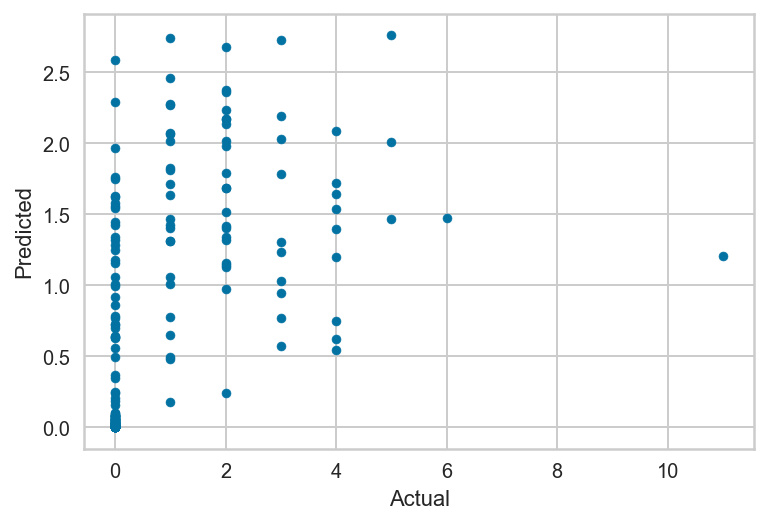

In [166]:
#Scatter plot to explore the relationship between actual points and predicted points
rf_pred_df_2.plot.scatter(x='Actual',y='Predicted')

Variable: sunrise Importance: 0.138
Variable: resultdir Importance: 0.134
Variable: cool Importance: 0.091
Variable: resultspeed Importance: 0.08
Variable: dewpoint Importance: 0.064
Variable: preciptotal Importance: 0.059
Variable: wetbulb Importance: 0.058
Variable: sealevel Importance: 0.058
Variable: depart Importance: 0.056
Variable: tmax Importance: 0.052
Variable: tavg Importance: 0.05
Variable: stnpressure Importance: 0.046
Variable: tmin Importance: 0.04
Variable: snowfall Importance: 0.039
Variable: sunset Importance: 0.036


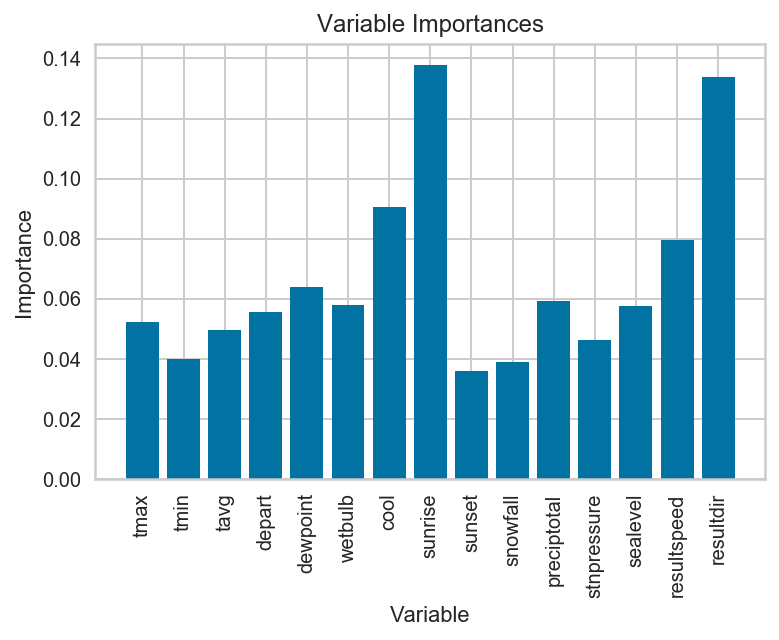

In [167]:
# Get feature importances
importances = list(best_grid_rf.feature_importances_)
feature_list = retained_names_92
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];


#Visualize the variable importances
# plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances'); 

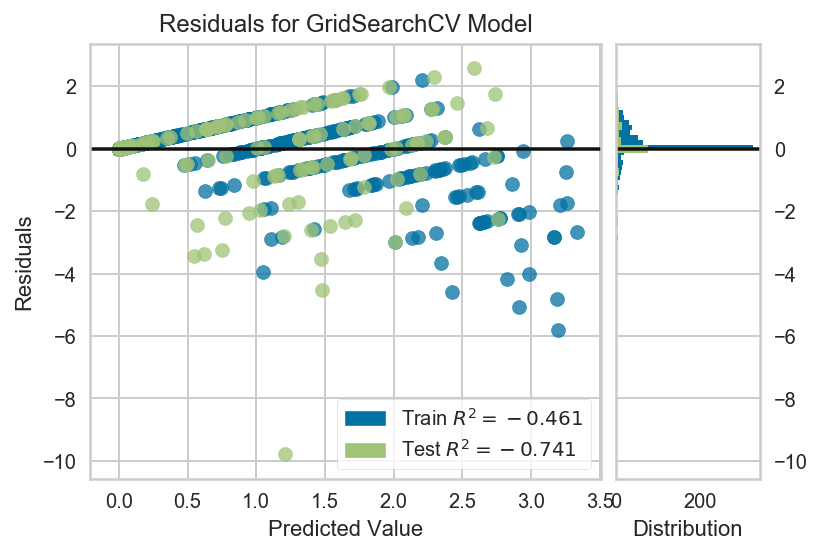

In [168]:
viz_rf_92 = residuals_plot(grid_search_rf, X_train_92_fin, y_train_92, X_test_92_fin, y_test_92)

Random forest gives us the most accuarte result, therefore we pick random forest as our best model. <br>

 <b>Random forst (Item 92): </b><br>
Mean Absolute Error: 0.7407167804738924<br>
Mean Squared Error: 1.76854229502818<br>
Root Mean Squared Error: 1.3298655176476228<br>

 <b>Our findings : </b><br>

Item 92 may be a seasonal item, because it is subject to cool, wind speed, and monthly precipitation variables. This result implies that colder days are correlated with the sales volumes of item 92.


<b>TOP 3 most important features: </b><br>

Variable 1: sunrise                    Importance: 0.138<br>

Variable 2: wind resultant direction   Importance: 0.134<br>

Variable 3: cool                       Importance: 0.091<br>

## BaggingRegressor item 44

In [169]:
from sklearn.ensemble import BaggingRegressor
bagging_regr = BaggingRegressor()
regr = bagging_regr.fit(X_train_44_fin, y_train_44)
regr_pred= regr.predict(X_test_44_fin)
#Evaluate the model's performances
evaluate_performances(y_test_44, regr_pred)

Mean Absolute Error: 42.986338797814206
Mean Squared Error: 3162.2842076502734
Root Mean Squared Error: 56.234190735265976


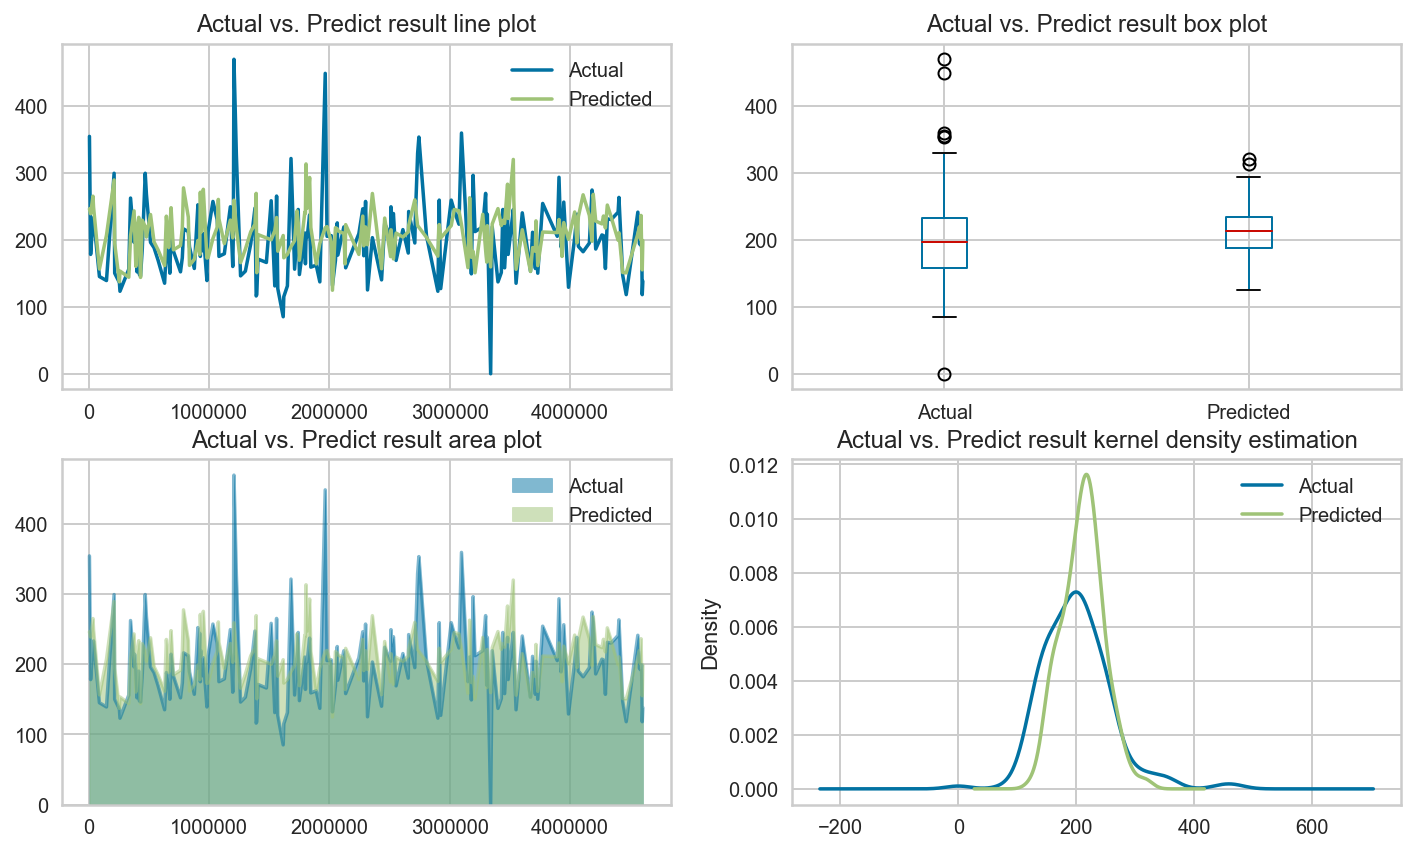

In [170]:
regr_pred_df = pd.DataFrame({'Actual': y_test_44, 'Predicted': regr_pred})
visualize_graph(regr_pred_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


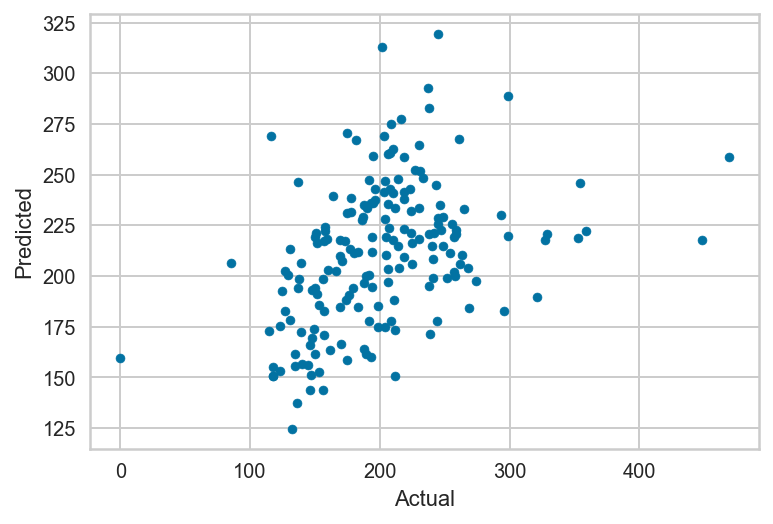

In [171]:
#Scatter plot to explore the relationship between actual points and predicted points
regr_pred_df.plot.scatter(x='Actual',y='Predicted')

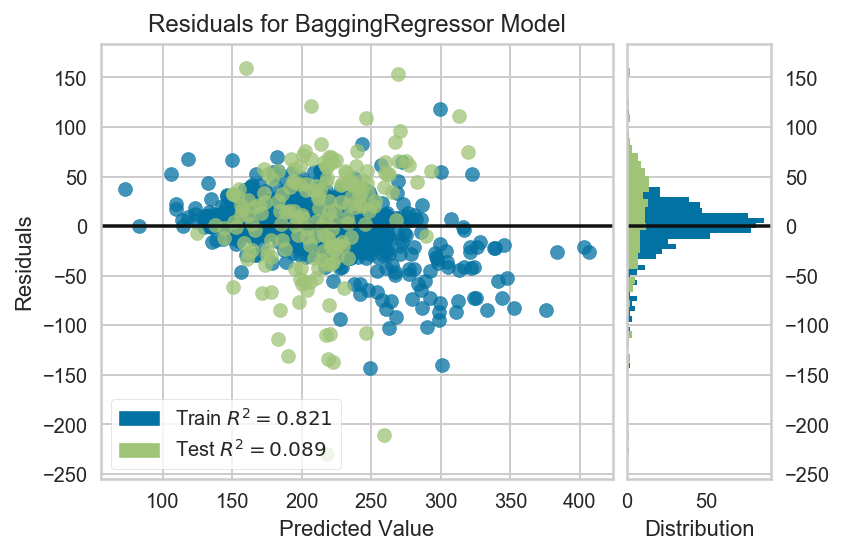

In [172]:
viz_bagging_44 = residuals_plot(regr, X_train_44_fin, y_train_44, X_test_44_fin, y_test_44)

We further use bagging regressor to train the model, and found that random forst still works the best.
Therefore, we decided to choose random forest as our best model.

## BaggingRegressor item 92

In [173]:
from sklearn.ensemble import BaggingRegressor
bagging_regr_2 = BaggingRegressor()
regr_2 = bagging_regr_2.fit(X_train_92_fin, y_train_92)
regr_pred= regr_2.predict(X_test_92_fin)
#Evaluate the model's performances
evaluate_performances(y_test_92, regr_pred)


Mean Absolute Error: 0.7863387978142076
Mean Squared Error: 1.959071038251366
Root Mean Squared Error: 1.3996681886259208


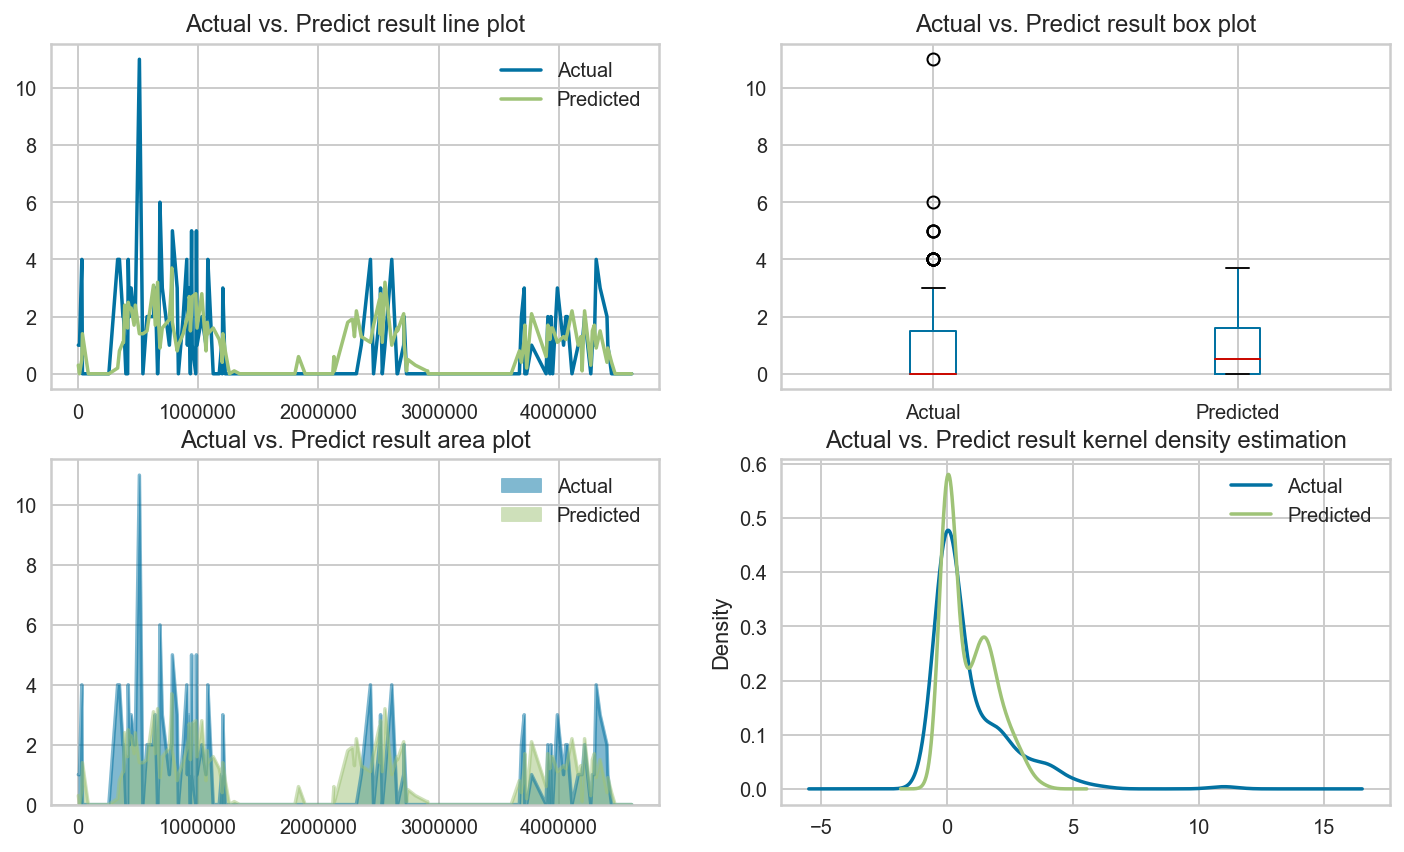

In [174]:
regr_pred_df_2 = pd.DataFrame({'Actual': y_test_92, 'Predicted': regr_pred})
visualize_graph(regr_pred_df_2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


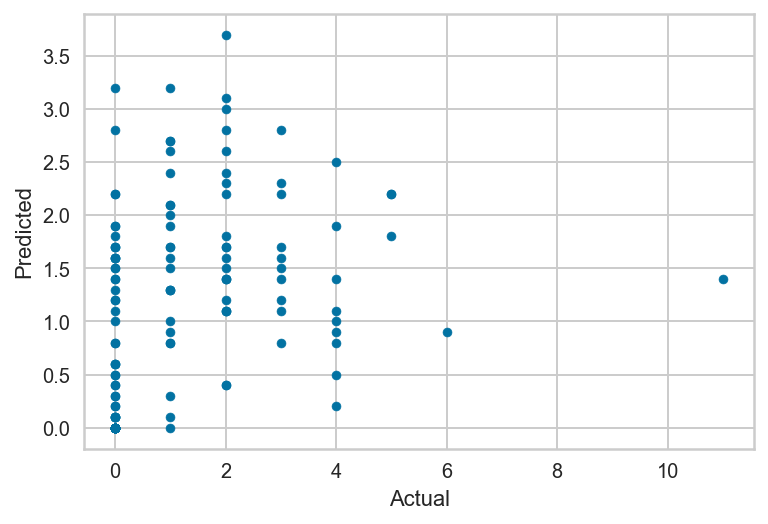

In [175]:
#Scatter plot to explore the relationship between actual points and predicted points
regr_pred_df_2.plot.scatter(x='Actual',y='Predicted')

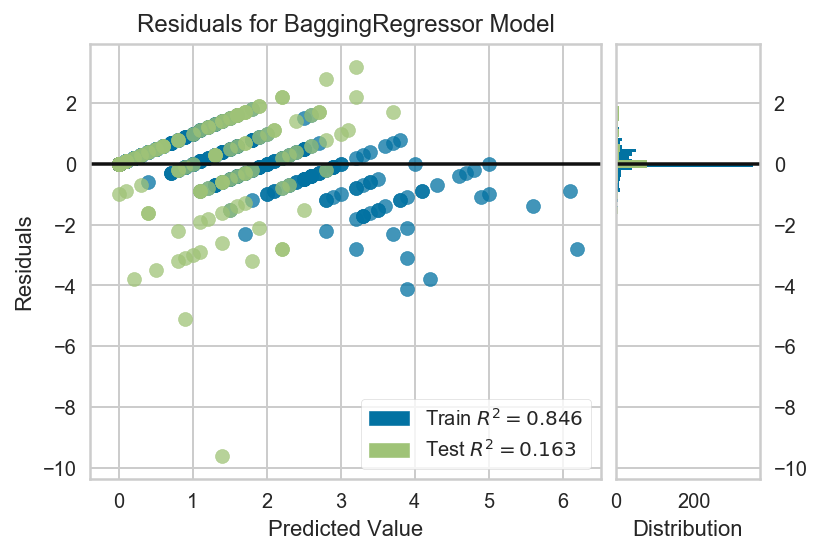

In [176]:
viz_bagging_92 = residuals_plot(regr_2, X_train_92_fin, y_train_92, X_test_92_fin, y_test_92)

We further use bagging regressor to train the model, and found that random forst still works the best.
Therefore, we decided to choose random forest as our best model.

### Conclusion based on our best model prediction

1. Different product reacts to different attributes. Therefore, if we put all products together to perform the analysis. The result would be less obvious.
2. Store 33 has the highest sales volumns across all stores.
3. Among store 33, we found that item 44 and item 9 may be daily necessities. Item 92, and item 93 may be products easily affected by weathers.
4. We picked item 44 and item 92 to perform the further analysis due to relatively more observe data on this two items.
5. After utilizing the machine learning model to perform the analysis. we found that:<br>

   a. Item 44: <br>
     a1) The volume of sales is stable over time.<br>
     a2) The best model can accurately predict long-term average sales volumes, but the outlier conditions can hardly be predicted. e.g. One possilbe outlier scenario: Increased demand for toilet paper due to coronavirus.<br>
     
   b. Item 92: <br>
    b1) The volume of sales is highly volatile over time. We guess this product could be a seasonal product.<br>
    b2) Item 92 is subject to cool, wind speed, and monthly precipitation variables. This result implies that colder days are correlated with the sales volumes of item 92.<br>




## Limitation and Next Steps

• Moving to overall prediction accuracy <br>
• Incorporation of other events, such as promotions and News. <br>